<img src = "../../Data/bgsedsc_0.jpg">

# Project: Decision trees

## Programming project: length of stay

In this project, you have to predict the length of stay (in days) of a patient that is entering an ICU (Intensive Care Unit) using decision tree models.

The dataset comes from MIMIC project (https://mimic.physionet.org/). MIMIC-III (Medical Information Mart for Intensive Care III) is a large, freely-available database comprising deidentified health-related data associated with over forty thousand patients who stayed in critical care units of the Beth Israel Deaconess Medical Center between 2001 and 2012.

Each row of *mimic_train.csv* correponds to one ICU stay (*hadm_id*+*icustay_id*) of one patient (*subject_id*). Column *LOS* is the length of stay of this patient, equal to discharge time minus admit time.
The remaining columns correspond to vitals of each patient (when entering the ICU), plus some general characteristics (age, gender, etc.), and their explanation can be found at *mimic_patient_metadata.csv*.
Please don't use any feature that you infer you don't know the first day of a patient in an ICU.

Note that the main cause/disease of patient contidition is embedded as a code at *ICD9_diagnosis* column. The meaning of this code can be found at *MIMIC_metadata_diagnose.csv*. **But** this is only the main one; a patient can have co-occurrent diseases (comorbidities). These secondary codes can be found at *extra_data/MIMIC_diagnoses.csv*.

Don't use features that you don't know the first day a patient enters the ICU, such as *HOSPITAL_EXPIRE_FLAG*

As performance metric, please use *RMSE* (root mean squared error).

Main tasks are:
+ Using *mimic_train.csv* file build a predictive model for *LOS* .
+ For this analysis there is an extra test dataset, *mimic_test_los.csv*. Apply your final model to this extra dataset and generate predictions following the same format as *mimic_kaggle_los_sample_submission.csv*. Once ready, you can submit to our Kaggle competition and iterate to improve the accuracy.

As a *bonus*, try different decision trees algorithms, even combine with other prediction models.  Try to assess which features are more important, and if possible the confidence interval of predictions.

You can follow those **steps** in your first implementation:
1. *Explore* and understand the dataset. 
2. Manage missing data.
2. Manage categorical features. E.g. create *dummy variables* for relevant categorical features, or build an ad hoc distance function.
3. Build a prediction model
5. Assess expected accuracy  of previous models using *cross-validation*. 
6. Predict on the test file, following same preparation steps (missing data, dummies, etc). Remember that you should be able to yield a prediction for all the rows of the test dataset. Submit to Kaggle to check performance.

For the in-class assignment, feel free to reduce the training dataset if you experience computational constraints.

## Main criteria for IN-CLASS grading
The weighting of these components will vary between the in-class and extended projects:
+ Code runs - 15%
+ Data preparation - 20%
+ DT method(s) have been used - 25%
+ Length of stay for each test patient is computed - 15%
+ Accuracy itself - 15%
+ Hyperparameter optimization - 10%
+ Neat and understandable code, with some titles and comments - 0%
+ Improved methods from what we discussed in class (properly explained/justified) - 0%


## Preliminaries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Set working directory
import os
#os.chdir('/Users/philine/Documents/GitHub/CML/mimic_icu_decisiontrees/') # local GitHub
#os.chdir('/Volumes/GoogleDrive/My Drive/mimic_icu_decisiontrees/') # local Gdrive
os.chdir('/content/drive/MyDrive/mimic_icu_decisiontrees') # Google Colab

In [ ]:
!pip install category_encoders
!pip install -U mlens
!pip install lime
!pip install shap
!pip install tensorflow

     |████████████████████████████████| 86 kB 3.0 MB/s 
     |████████████████████████████████| 227 kB 5.2 MB/s 
     |████████████████████████████████| 275 kB 3.9 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=78d3cd7ac3124d189a00fa65b9f953f01ebd815c88b4b765da90df9d697a9047
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime
     |████████████████████████████████| 564 kB 5.0 MB/s 
     |████████████████████████████████| 462 kB 5.2 MB/s 


In [ ]:
# Import relevant packages
%matplotlib inline
import matplotlib.pylab as plt 

from utils.helper_functions import *

import pandas as pd
import numpy as np
from math import sqrt

import sklearn
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR 

from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV 
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler

from sklearn.metrics import  r2_score, mean_squared_error
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import category_encoders as ce

import pickle
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import ExtraTreesRegressor, AdaBoostRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn import tree

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import StackingRegressor
from matplotlib import pyplot

import mlens
from mlens.visualization import corrmat
from mlens.ensemble import SuperLearner, BlendEnsemble, Subsemble, SequentialEnsemble

import lime
import lime.lime_tabular
import shap

from sklearn.neural_network import MLPRegressor

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

SEED = 42

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
[MLENS] backend: threading


In [ ]:
# Starter code to load data
# Training dataset
data=pd.read_csv('data/mimic_train.csv')
data.head()

HOSPITAL_EXPIRE_FLAG  subject_id  hadm_id  icustay_id  HeartRate_Min  \
0                     0       55440   195768      228357           89.0   
1                     0       76908   126136      221004           63.0   
2                     0       95798   136645      296315           81.0   
3                     0       40708   102505      245557           76.0   
4                     0       28424   127337      225281            NaN   

   HeartRate_Max  HeartRate_Mean  SysBP_Min  SysBP_Max  SysBP_Mean  ...  \
0          145.0      121.043478       74.0      127.0  106.586957  ...   
1          110.0       79.117647       89.0      121.0  106.733333  ...   
2           98.0       91.689655       88.0      138.0  112.785714  ...   
3          128.0       98.857143       84.0      135.0  106.972973  ...   
4            NaN             NaN        NaN        NaN         NaN  ...   

          Diff  ADMISSION_TYPE  INSURANCE           RELIGION  MARITAL_STATUS  \
0 -61961.78470       EMERGENCY   Medicare  PROTESTANT QUAKER          SINGLE   
1 -43146.18378       EMERGENCY    Private       UNOBTAINABLE         MARRIED   
2 -42009.96157       EMERGENCY   Medicare  PROTESTANT QUAKER       SEPARATED   
3 -43585.37922        ELECTIVE   Medicare      NOT SPECIFIED         WIDOWED   
4 -50271.76602       EMERGENCY   Medicare             JEWISH         WIDOWED   

                ETHNICITY                  DIAGNOSIS  ICD9_diagnosis  \
0                   WHITE     GASTROINTESTINAL BLEED            5789   
1                   WHITE  ESOPHAGEAL FOOD IMPACTION           53013   
2  BLACK/AFRICAN AMERICAN             UPPER GI BLEED           56983   
3                   WHITE          HIATAL HERNIA/SDA            5533   
4                   WHITE             ABDOMINAL PAIN           56211   

   FIRST_CAREUNIT     LOS  
0            MICU  4.5761  
1            MICU  0.7582  
2            MICU  3.7626  
3            SICU  3.8734  
4           TSICU  5.8654  

[5 rows x 41 columns]

In [ ]:
# Test dataset (to produce predictions)
data_test=pd.read_csv('data/mimic_test_los.csv')
data_test.sort_values('icustay_id').head()

subject_id  hadm_id  icustay_id  HeartRate_Min  HeartRate_Max  \
4930       93535   121562      200011           56.0           82.0   
1052       30375   177945      200044            NaN            NaN   
3412       73241   149216      200049           54.0           76.0   
1725       99052   129142      200063           85.0          102.0   
981        51698   190004      200081           82.0          133.0   

      HeartRate_Mean  SysBP_Min  SysBP_Max  SysBP_Mean  DiasBP_Min  ...  \
4930       71.205128      123.0      185.0  156.411765        37.0  ...   
1052             NaN        NaN        NaN         NaN         NaN  ...   
3412       64.833333       95.0      167.0  114.545455        33.0  ...   
1725       92.560976       91.0      131.0  108.365854        42.0  ...   
981        94.323529       86.0      143.0  111.093750        47.0  ...   

                ADMITTIME         Diff  ADMISSION_TYPE  INSURANCE  \
4930  2188-08-05 20:27:00 -64881.43517       EMERGENCY   Medicare   
1052  2135-07-07 16:13:00 -46540.62661       EMERGENCY   Medicare   
3412  2118-08-14 22:27:00 -38956.85890       EMERGENCY    Private   
1725  2141-03-09 23:19:00 -47014.25437       EMERGENCY   Medicaid   
981   2142-02-23 06:56:00 -47377.26087       EMERGENCY   Medicare   

           RELIGION  MARITAL_STATUS              ETHNICITY  \
4930         JEWISH          SINGLE                  WHITE   
1052       CATHOLIC         WIDOWED                  WHITE   
3412         JEWISH         MARRIED                  WHITE   
1725  NOT SPECIFIED          SINGLE  UNKNOWN/NOT SPECIFIED   
981           OTHER         MARRIED             PORTUGUESE   

                     DIAGNOSIS  ICD9_diagnosis  FIRST_CAREUNIT  
4930  ASTHMA;COPD EXACERBATION           49322            MICU  
1052                HEAD BLEED           85220            SICU  
3412    HEPATIC ENCEPHALOPATHY            5722            MICU  
1725         TYPE A DISSECTION           44101            CSRU  
981         PULMONARY EMBOLISM           41519             CCU  

[5 rows x 39 columns]

In [ ]:
# Sample output prediction file
pred_sample=pd.read_csv('data/mimic_kaggle_los_sample_submission.csv')
pred_sample.sort_values('icustay_id').head()

icustay_id       LOS
663       200011  3.701046
4608      200044  3.701046
1186      200049  3.701046
1245      200063  3.701046
606       200081  3.701046

In [ ]:
# drop hospital expiry flag from columns
data.drop(columns = ['HOSPITAL_EXPIRE_FLAG'], inplace=True)
cols_diff = data.columns.difference(data_test.columns)
print(cols_diff)

Index(['LOS'], dtype='object')


## Incorporate comorbidities into the data set
For incorporating the comorbidity data I looked for a way that would retain as much information as possible, whilst not drastically increasing the dimensionality of the main dataset.
I tried the following three approaches:

1. Count the number of comorbidities of each patient
2. Make dummies for parent ICD9 categories as specified on wikipedia: https://en.wikipedia.org/wiki/List_of_ICD-9_codes. For each patient count the number of comorbidities within each parent group. Complement this with dummies for the 10 most frequent comorbidities.
3. Construct a 'Length of stay proxy' for each ICD9 code by combining the comorbidity data with the LOS. This yields the average length of stay for all patients with a particular comorbidity. Calculate the distributions of this LOS proxy associated with the comorbidities for each patient and merge this back to the main dataset.

Approach 1 has the highest information loss. Approach 2 was an improvement on 1, but failed to account for the different severities of diseases within each parent category. I thus combine the first with the third option, as this yielded the best results.

In [ ]:
# Load comorbidity data
comorbidity = pd.read_csv('data/extra_data/MIMIC_diagnoses.csv')
comorbidity.head()

SUBJECT_ID  HADM_ID  SEQ_NUM ICD9_CODE
0         256   108811      1.0     53240
1         256   108811      2.0     41071
2         256   108811      3.0     53560
3         256   108811      4.0     40390
4         256   108811      5.0      5859

In [ ]:
comorbidity.columns

Index(['SUBJECT_ID', 'HADM_ID', 'SEQ_NUM', 'ICD9_CODE'], dtype='object')

In [ ]:
# Reformat columns
comorbidity = comorbidity.rename(columns=str.lower)
comorbidity = comorbidity.dropna()
comorbidity.head()

subject_id  hadm_id  seq_num icd9_code
0         256   108811      1.0     53240
1         256   108811      2.0     41071
2         256   108811      3.0     53560
3         256   108811      4.0     40390
4         256   108811      5.0      5859

In [ ]:
# Check for duplicates
comorbidity.duplicated().value_counts()

False    651000
dtype: int64

### Count number of comorbidities for each patient

In [ ]:
# Collapse dataset on HADM_ID with max SEQ_NUM
# The SEQ_NUM can be interpreted as the number of comorbidities for an individual during a particular hospital stay. 
comorbidity_count = comorbidity.groupby(['subject_id', 'hadm_id']).max().reset_index()
comorbidity_count.rename(columns={"seq_num": "comorbidity_count"}, inplace=True)
comorbidity_count['comorbidity_count'] = comorbidity_count['comorbidity_count'].astype(int)

comorbidity_count = comorbidity_count.drop(columns=['icd9_code'])
comorbidity_count.head()

subject_id  hadm_id  comorbidity_count
0           2   163353                  3
1           3   145834                  9
2           4   185777                  9
3           5   178980                  3
4           6   107064                  8

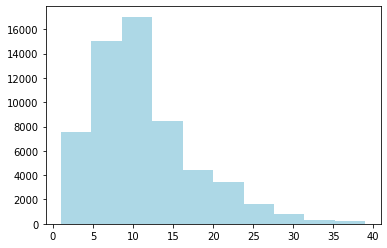

In [ ]:
# Look at distribution of the count variable
plt.hist(comorbidity_count['comorbidity_count'], color="lightblue");

In [ ]:
# Merge comorbidity count back to main dataset
df = pd.merge(left=data, right=comorbidity_count, how='left', on=['subject_id', 'hadm_id'])
df_test = pd.merge(left=data_test, right=comorbidity_count, how='left', on=['subject_id', 'hadm_id'])

df.head()
df_test.head()

subject_id  hadm_id  icustay_id  HeartRate_Min  HeartRate_Max  \
0       64058   146725      208169           58.0           90.0   
1       55871   108789      251754           91.0          145.0   
2       42892   139885      242171          106.0          132.0   
3       66629   173017      263035           72.0          105.0   
4       79851   171573      279388           85.0          124.0   

   HeartRate_Mean  SysBP_Min  SysBP_Max  SysBP_Mean  DiasBP_Min  ...  \
0       85.244898       77.0      153.0   98.490909        40.0  ...   
1      115.055556       73.0      143.0  101.210526        42.0  ...   
2      117.750000       93.0      137.0  116.222222        51.0  ...   
3       83.627119       72.0      168.0  126.981818        39.0  ...   
4       98.600000       86.0      144.0  110.666667        52.0  ...   

          Diff  ADMISSION_TYPE  INSURANCE       RELIGION  MARITAL_STATUS  \
0 -67454.42740        ELECTIVE   Medicare       CATHOLIC         MARRIED   
1 -34204.08546       EMERGENCY    Private  NOT SPECIFIED         MARRIED   
2 -38710.61714        ELECTIVE   Medicare       CATHOLIC         MARRIED   
3 -54902.54313       EMERGENCY    Private   EPISCOPALIAN         WIDOWED   
4 -33906.93488       EMERGENCY   Medicare       CATHOLIC          SINGLE   

   ETHNICITY                                          DIAGNOSIS  \
0      WHITE  AORTIC STENOSIS\CORONARY ARTERY BYPASS GRAFT W...   
1      WHITE                                      HYPERGLYCEMIA   
2      WHITE                                  KIDNEY STONES/SDA   
3      WHITE                               RIGHT FEMUR FRACTURE   
4      WHITE                         PNEUMONIA;RAPID AF;HYPOXIA   

   ICD9_diagnosis  FIRST_CAREUNIT  comorbidity_count  
0            4241            CSRU                 20  
1           25013            MICU                 11  
2            5920            MICU                 12  
3           82120             CCU                 16  
4           51884            MICU                 29  

[5 rows x 40 columns]

### Target encode comorbidity data with proxy for LOS

In [ ]:
# Merge HOSPITAL_EXPIRE_FLAG to comorbidity dataset
comorbidity = pd.merge(left=comorbidity,
                       right=data[['subject_id', 'hadm_id', 'LOS']],
                       how='left',
                       on=['subject_id', 'hadm_id'])

comorbidity.head()

subject_id  hadm_id  seq_num icd9_code     LOS
0         256   108811      1.0     53240  1.7219
1         256   108811      2.0     41071  1.7219
2         256   108811      3.0     53560  1.7219
3         256   108811      4.0     40390  1.7219
4         256   108811      5.0      5859  1.7219

In [ ]:
# Construct a length of stay proxy for each ICD9 code
#comorbidity['LOS_proxy'] = comorbidity['LOS'].groupby(comorbidity['icd9_code']).transform('mean')
comorbidity['LOS_proxy'] = comorbidity['LOS'].groupby(comorbidity['icd9_code']).transform('median')
comorbidity[['icd9_code', 'LOS_proxy']].head()

icd9_code  LOS_proxy
0     53240    2.06640
1     41071    2.74830
2     53560    1.66650
3     40390    2.17250
4      5859    2.21745

In [ ]:
comorbidity['LOS'].describe()

count    309894.000000
mean          4.554183
std           6.289310
min           0.056600
25%           1.281700
50%           2.339900
75%           4.926800
max         101.739000
Name: LOS, dtype: float64

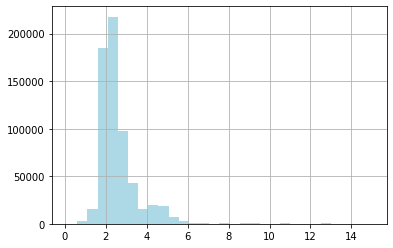

In [ ]:
comorbidity.query("LOS_proxy < 15")['LOS_proxy'].hist(bins = 30, color="lightblue")

In [ ]:
comorbidity_enc = comorbidity.groupby(['subject_id', 'hadm_id']).agg({'LOS_proxy': ['mean', 'median', 'min', 'max']})
comorbidity_enc.columns = ['LOS_mean', 'LOS_median', 'LOS_min', 'LOS_max']
comorbidity_enc = comorbidity_enc.reset_index()
comorbidity_enc.head(10)

subject_id  hadm_id  LOS_mean  LOS_median  LOS_min  LOS_max
0           2   163353  4.874500     4.87450   4.8745  4.87450
1           3   145834  2.868433     2.74830   2.3724  4.06105
2           4   185777  3.273583     2.90085   2.1441  5.21340
3           5   178980  4.874500     4.87450   4.8745  4.87450
4           6   107064  2.510375     2.28550   2.0473  3.62510
5           7   118037  4.874500     4.87450   4.8745  4.87450
6           8   159514  4.874500     4.87450   4.8745  4.87450
7           9   150750  2.521360     2.45270   2.0127  3.44180
8          10   184167       NaN         NaN      NaN      NaN
9          11   194540  1.031600     1.03160   1.0316  1.03160

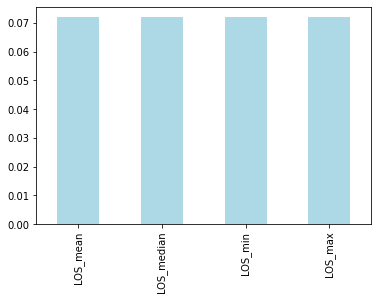

In [ ]:
missing = comorbidity_enc.isnull().sum() / len(df)
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar(color="lightblue")

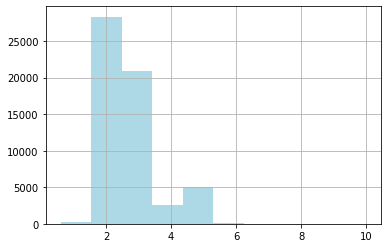

In [ ]:
comorbidity_enc.query("LOS_mean < 10")['LOS_mean'].hist(color="lightblue")

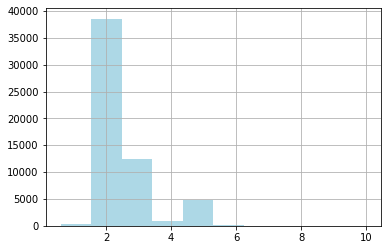

In [ ]:
comorbidity_enc.query("LOS_median < 10")['LOS_median'].hist(color="lightblue")

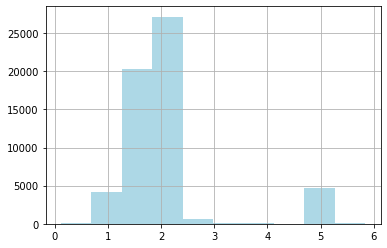

In [ ]:
comorbidity_enc.query("LOS_min < 6")['LOS_min'].hist(color="lightblue")

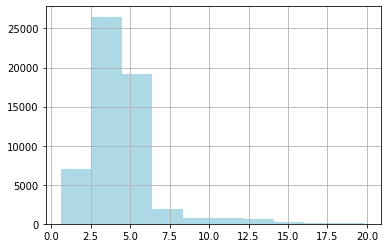

In [ ]:
comorbidity_enc.query("LOS_max < 20")['LOS_max'].hist(color="lightblue")

In [ ]:
# Merge summary statistics of LOS proxy associated with comorbidities of each patient back to main dataframe
df = pd.merge(left=df, 
                right=comorbidity_enc[['subject_id', 'hadm_id', 'LOS_mean', 'LOS_median', 'LOS_min', 'LOS_max']],
                how='left', on=['subject_id', 'hadm_id'])

df_test = pd.merge(left=df_test, 
        right=comorbidity_enc[['subject_id', 'hadm_id', 'LOS_mean', 'LOS_median', 'LOS_min', 'LOS_max']],
        how='left', on=['subject_id', 'hadm_id'])

print(df.shape)
print(df_test.shape)

(20885, 45)
(5221, 44)


## Data Exploration

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20885 entries, 0 to 20884
Data columns (total 45 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   subject_id         20885 non-null  int64  
 1   hadm_id            20885 non-null  int64  
 2   icustay_id         20885 non-null  int64  
 3   HeartRate_Min      18698 non-null  float64
 4   HeartRate_Max      18698 non-null  float64
 5   HeartRate_Mean     18698 non-null  float64
 6   SysBP_Min          18677 non-null  float64
 7   SysBP_Max          18677 non-null  float64
 8   SysBP_Mean         18677 non-null  float64
 9   DiasBP_Min         18676 non-null  float64
 10  DiasBP_Max         18676 non-null  float64
 11  DiasBP_Mean        18676 non-null  float64
 12  MeanBP_Min         18699 non-null  float64
 13  MeanBP_Max         18699 non-null  float64
 14  MeanBP_Mean        18699 non-null  float64
 15  RespRate_Min       18696 non-null  float64
 16  RespRate_Max       186

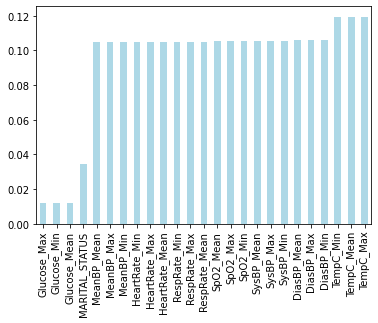

In [ ]:
# look at missing values in train set
missing = df.isnull().sum() / len(df)
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar(color="lightblue")

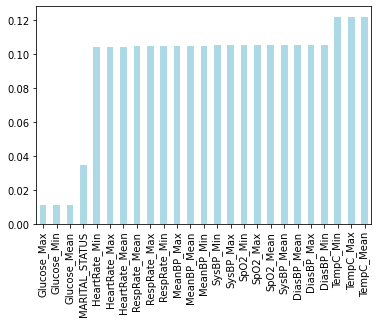

In [ ]:
# look at missing values in test set
missing_test = df_test.isnull().sum() / len(df_test)
missing_test = missing_test[missing_test > 0]
missing_test.sort_values(inplace=True)
missing_test.plot.bar(color="lightblue")

Except for marital status, only numerical variables are missing.

In [ ]:
cols = df.columns
cols

Index(['subject_id', 'hadm_id', 'icustay_id', 'HeartRate_Min', 'HeartRate_Max',
       'HeartRate_Mean', 'SysBP_Min', 'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min',
       'DiasBP_Max', 'DiasBP_Mean', 'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean',
       'RespRate_Min', 'RespRate_Max', 'RespRate_Mean', 'TempC_Min',
       'TempC_Max', 'TempC_Mean', 'SpO2_Min', 'SpO2_Max', 'SpO2_Mean',
       'Glucose_Min', 'Glucose_Max', 'Glucose_Mean', 'GENDER', 'DOB',
       'ADMITTIME', 'Diff', 'ADMISSION_TYPE', 'INSURANCE', 'RELIGION',
       'MARITAL_STATUS', 'ETHNICITY', 'DIAGNOSIS', 'ICD9_diagnosis',
       'FIRST_CAREUNIT', 'LOS', 'comorbidity_count', 'LOS_mean', 'LOS_median',
       'LOS_min', 'LOS_max'],
      dtype='object')

In [ ]:
num_feat = df.select_dtypes(exclude=['object', 'category']).columns
num_feat = num_feat.drop(['subject_id', 'hadm_id', 'icustay_id'])
num_feat

Index(['HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min',
       'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean',
       'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min',
       'RespRate_Max', 'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean',
       'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max',
       'Glucose_Mean', 'Diff', 'LOS', 'comorbidity_count', 'LOS_mean',
       'LOS_median', 'LOS_min', 'LOS_max'],
      dtype='object')

In [ ]:
df[num_feat].describe()

HeartRate_Min  HeartRate_Max  HeartRate_Mean     SysBP_Min  \
count   18698.000000   18698.000000    18698.000000  18677.000000   
mean       69.705904     105.239801       85.180250     91.110564   
std        14.869840      20.922613       15.318208     17.532534   
min         2.000000      39.000000       34.714286      5.000000   
25%        60.000000      90.000000       74.272727     81.000000   
50%        69.000000     103.000000       84.131183     90.000000   
75%        79.000000     118.000000       95.185588    101.000000   
max       141.000000     280.000000      163.875000    181.000000   

          SysBP_Max    SysBP_Mean    DiasBP_Min    DiasBP_Max   DiasBP_Mean  \
count  18677.000000  18677.000000  18676.000000  18676.000000  18676.000000   
mean     150.725920    119.145423     44.327854     88.360784     62.511614   
std       23.833793     16.701503     11.909852     19.285554     11.010790   
min       46.000000     46.000000      4.000000     27.000000     17.000000   
25%      134.000000    107.100000     37.000000     75.000000     54.950952   
50%      148.000000    116.901961     44.000000     86.000000     61.423660   
75%      164.000000    129.465116     51.000000     98.000000     68.954545   
max      323.000000    202.172414    105.000000    294.000000    121.489362   

         MeanBP_Min  ...   Glucose_Min   Glucose_Max  Glucose_Mean  \
count  18699.000000  ...  20632.000000  20632.000000  20632.000000   
mean      56.293064  ...    106.781975    182.129604    138.856428   
std       14.348780  ...     35.178811     92.665603     44.933145   
min        1.000000  ...      2.000000     42.000000     42.000000   
25%       49.000000  ...     86.000000    126.000000    110.750000   
50%       57.000000  ...    102.000000    161.000000    128.666667   
75%       64.000000  ...    121.000000    206.000000    154.578571   
max      122.000000  ...    563.000000   2440.000000    771.900000   

               Diff           LOS  comorbidity_count      LOS_mean  \
count  20885.000000  20885.000000       20885.000000  20885.000000   
mean  -51617.069830      3.701046          14.838113      2.513606   
std    10686.395846      5.175721           7.301290      0.460896   
min   -72740.274440      0.056600           1.000000      1.021100   
25%   -60864.454110      1.165400           9.000000      2.220425   
50%   -51561.703460      2.020800          14.000000      2.427648   
75%   -42327.560030      3.915800          19.000000      2.711071   
max   -32157.494580    101.739000          39.000000     13.208823   

         LOS_median       LOS_min       LOS_max  
count  20885.000000  20885.000000  20885.000000  
mean       2.310258      1.736157      4.436333  
std        0.321298      0.300524      2.731969  
min        0.760200      0.117100      1.021100  
25%        2.101825      1.562650      2.978600  
50%        2.231600      1.824950      3.855700  
75%        2.452700      1.967500      4.798400  
max        9.689450      5.649650    101.739000  

[8 rows x 31 columns]

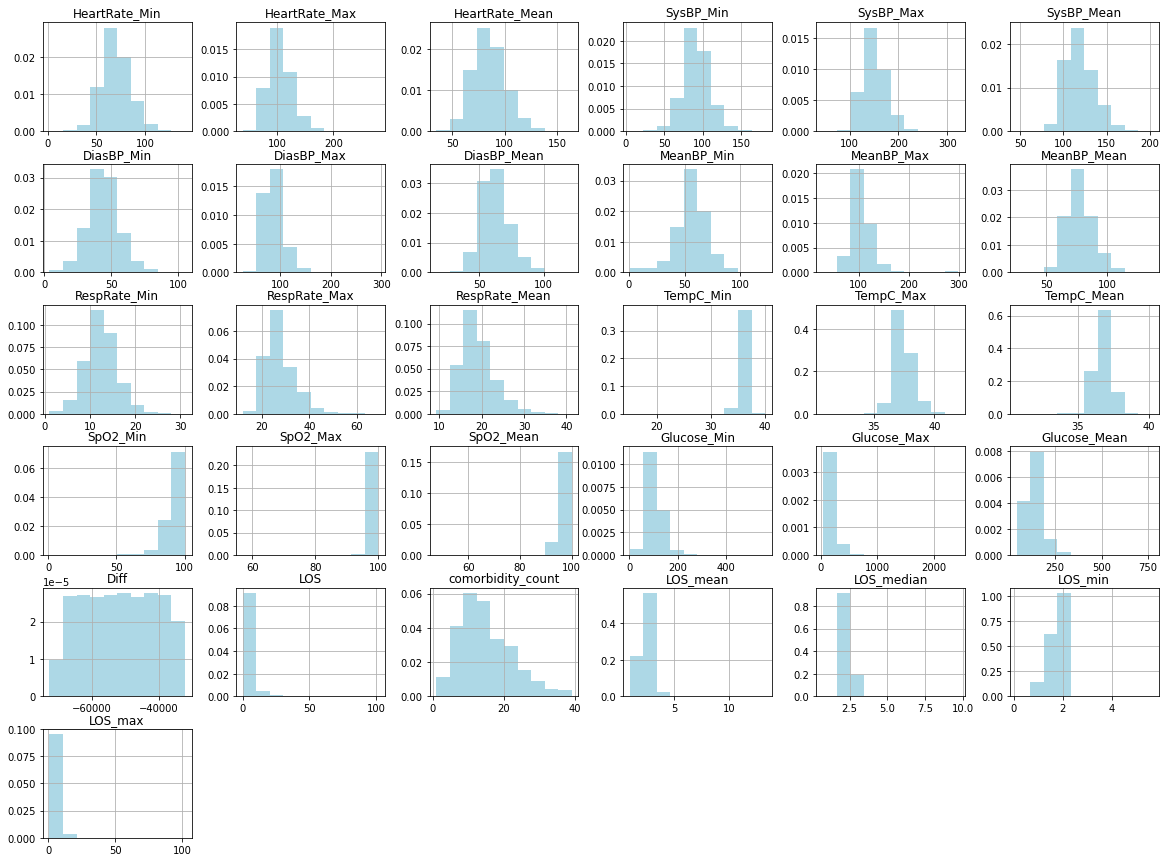

In [ ]:
# make distribution plots of numerical variables to see if log transformations are necessary
df[num_feat].hist(density=True, figsize=(20, 15), color="lightblue");

In [ ]:
# calculate skewness
df[num_feat].skew(skipna = True).sort_values()

SpO2_Max            -9.698139
SpO2_Min            -5.003111
SpO2_Mean           -4.552082
TempC_Min           -3.030848
LOS_min             -0.696284
MeanBP_Min          -0.603259
TempC_Mean          -0.443080
Diff                -0.007335
SysBP_Min            0.117428
DiasBP_Min           0.194609
HeartRate_Min        0.200573
RespRate_Min         0.257232
TempC_Max            0.273242
HeartRate_Mean       0.332196
SysBP_Mean           0.561620
DiasBP_Mean          0.602822
MeanBP_Mean          0.606691
HeartRate_Max        0.662679
SysBP_Max            0.728849
comorbidity_count    0.768498
RespRate_Mean        0.928514
RespRate_Max         1.244570
DiasBP_Max           1.256793
Glucose_Min          2.045073
LOS_median           2.190538
Glucose_Mean         2.207931
LOS_mean             2.485095
MeanBP_Max           3.091070
Glucose_Max          4.058114
LOS                  4.864686
LOS_max              6.342244
dtype: float64

The acceptable value of skewness is considered to be between -3 and +3. If the value of skewness falls on either side of this range then it indicates that the skewness must be fixed. For the following variables the skewness is outside the acceptable range:

+ negatively skewed: SpO2_Max, SpO2_Min, SpO2_Mean, TempC_Min
+ positively skewed: MeanBP_Max, Glucose_Max, LOS

Skewness can be fixed by log transforming the affected variables. I implement this in one instance of my model. However, this decreases both my in-sample and kaggle performance, which is why I drop this idea.

Source: https://yashowardhanshinde.medium.com/what-is-skewness-in-data-how-to-fix-skewed-data-in-python-a792e98c0fa6

<function matplotlib.pyplot.show>

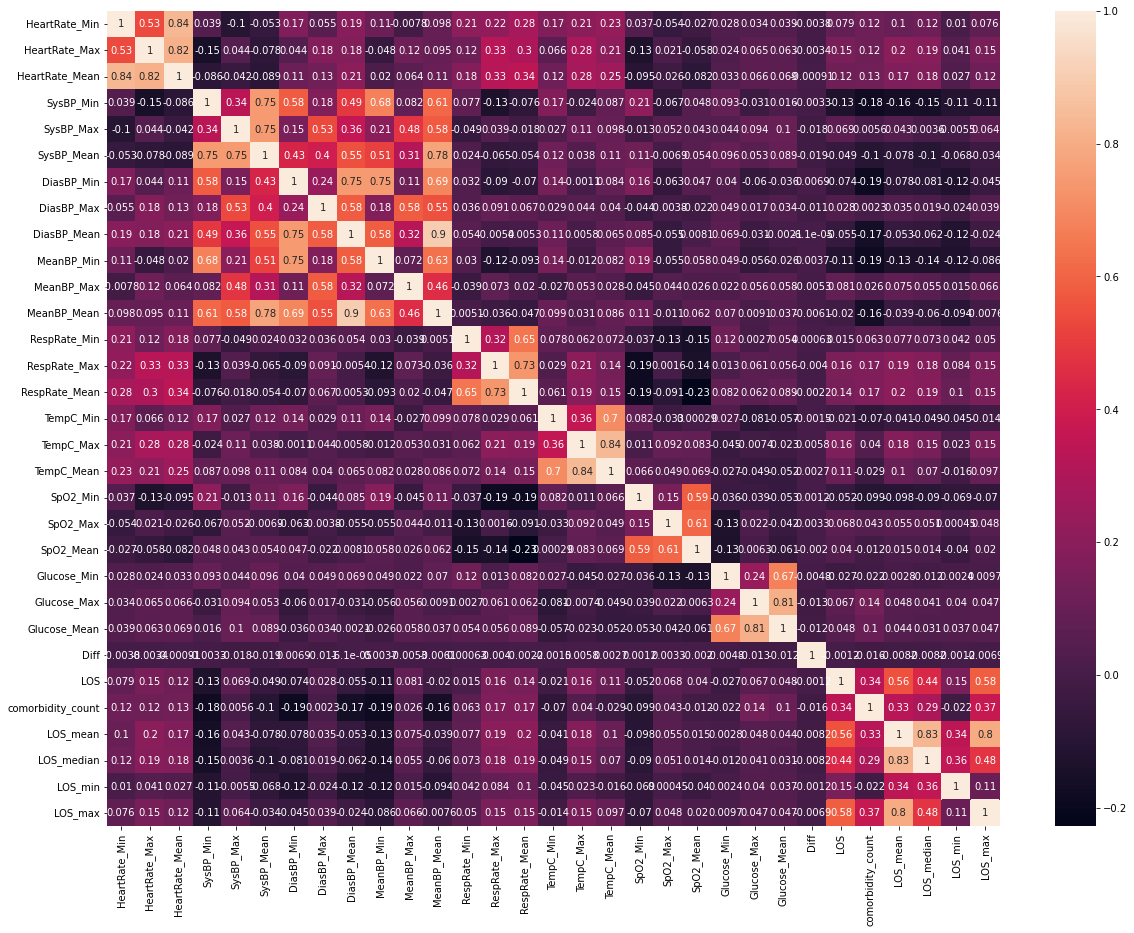

In [ ]:
fig, ax = plt.subplots(figsize=(20, 15))
sns.heatmap(df[num_feat].corr(), annot=True)
plt.show

As expected, I find that different summary statistics of the same variable e.g. *Heartrate_Min*, *Heartrate_Max* and *Heartrate_Mean* are highly correlated. I have a particularly large correlation cluster around blood pressure as this factor is summarized by three different  variables: *SysBP*, *DiasBP* and *MeanBP*. Similarly, all variables obtained from the comorbidity data are highly correlated with each other and the outcome variable LOS. This makes intuitive sense as *LOS* was used to encode all comorbidity variables except for the comorbidity count. Judging from this correlation matrix, I would expect the variables constructed from the comorbidity data to have the highest feature importance due to their high correlation with the outcome variable *LOS*.

In [ ]:
df[num_feat].corr()['LOS'][:].sort_values(ascending=False)

LOS                  1.000000
LOS_max              0.582934
LOS_mean             0.557913
LOS_median           0.439934
comorbidity_count    0.335002
TempC_Max            0.164657
RespRate_Max         0.159270
LOS_min              0.154050
HeartRate_Max        0.150670
RespRate_Mean        0.141701
HeartRate_Mean       0.116884
TempC_Mean           0.106119
MeanBP_Max           0.081008
HeartRate_Min        0.079271
SysBP_Max            0.068940
SpO2_Max             0.067647
Glucose_Max          0.066877
Glucose_Mean         0.048248
SpO2_Mean            0.039658
DiasBP_Max           0.027848
RespRate_Min         0.015433
Diff                -0.001248
MeanBP_Mean         -0.020409
TempC_Min           -0.020681
Glucose_Min         -0.027488
SysBP_Mean          -0.048819
SpO2_Min            -0.052424
DiasBP_Mean         -0.054757
DiasBP_Min          -0.074366
MeanBP_Min          -0.111719
SysBP_Min           -0.132064
Name: LOS, dtype: float64

I calculate the correlation of each individual numerical feature with the outcome variable *LOS* to get a better summary of feature associations with the target variable. I find strong correlations with *LOS* for the following variables:
+ positive: LOS_max, LOS_mean, LOS_median, comorbidity_count
+ negative: SysBP_Min, MeanBP_Min

In [ ]:
cat_feat = df.select_dtypes(include=['object', 'category']).columns
cat_feat

Index(['GENDER', 'DOB', 'ADMITTIME', 'ADMISSION_TYPE', 'INSURANCE', 'RELIGION',
       'MARITAL_STATUS', 'ETHNICITY', 'DIAGNOSIS', 'ICD9_diagnosis',
       'FIRST_CAREUNIT'],
      dtype='object')

In [ ]:
df[cat_feat].nunique()

GENDER                2
DOB               14007
ADMITTIME         19714
ADMISSION_TYPE        3
INSURANCE             5
RELIGION             17
MARITAL_STATUS        7
ETHNICITY            41
DIAGNOSIS          6193
ICD9_diagnosis     1853
FIRST_CAREUNIT        5
dtype: int64

In [ ]:
for col in cat_feat:
    print(df[col].value_counts())

M    11759
F     9126
Name: GENDER, dtype: int64
2117-08-07 00:00:00    26
2096-10-22 00:00:00    16
2112-11-14 00:00:00    16
2105-05-05 00:00:00    15
2144-09-28 00:00:00    15
                       ..
2097-11-11 00:00:00     1
2110-12-16 00:00:00     1
1895-07-20 00:00:00     1
2137-12-05 00:00:00     1
2143-05-24 00:00:00     1
Name: DOB, Length: 14007, dtype: int64
2165-02-25 11:40:00    5
2150-11-03 22:05:00    5
2169-10-31 20:11:00    5
2177-04-13 17:36:00    4
2176-02-27 17:39:00    4
                      ..
2170-06-03 20:01:00    1
2122-05-22 15:15:00    1
2170-01-19 22:02:00    1
2150-06-19 03:23:00    1
2189-02-19 07:15:00    1
Name: ADMITTIME, Length: 19714, dtype: int64
EMERGENCY    17817
ELECTIVE      2848
URGENT         220
Name: ADMISSION_TYPE, dtype: int64
Medicare      11718
Private        6245
Medicaid       2117
Government      611
Self Pay        194
Name: INSURANCE, dtype: int64
CATHOLIC                  7655
NOT SPECIFIED             5398
PROTESTANT QUAKER     

## Feature Manipulation

### Log transform skewed variables
I looked at log transformations of my skewed variables. However, this decreased the performance of my model, so I am no longer pursuing this in my final version.

### Make an Age variable
The age variable is created using the DOB and ADMITTIME variables. I subtract the difference given by the Diff column in order to get dates that have a real meaning. Then I calculate the time difference between these two dates in order to determine the age of an individual. Note that individuals older than 89 are encoded as 300. We thus have observations with age>300. I recode these to age=90.

In [ ]:
import datetime as dt

for my_df in [df, df_test]:
# Convert admittime to date, adding "Diff" to make the dates realistic
    my_df['ADMITTIME'] = (pd.to_datetime(my_df['ADMITTIME']) + my_df["Diff"].apply(lambda x: dt.timedelta(x))).apply(lambda x: x.date())
# Convert dob to date, adding "Diff" to make the dates realistic
    my_df['DOB'] = (pd.to_datetime(my_df['DOB']) + my_df["Diff"].apply(lambda x: dt.timedelta(x))).apply(lambda x: x.date())
# Convert to age in years
    my_df['age'] = my_df.apply(lambda e: (e['ADMITTIME'] - e['DOB']).days/365.25, axis=1)
    
# Delete variables related to age
df = df.drop(columns=['DOB', 'Diff'])
df_test = df_test.drop(columns=['DOB', 'Diff'])

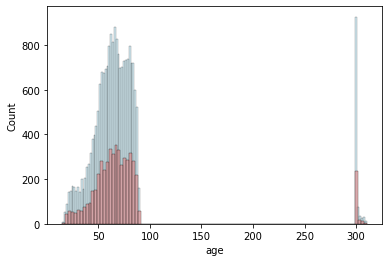

In [ ]:
# Plot distribution of age
sns.histplot(data=df, x="age", color="lightblue", alpha=0.5)
sns.histplot(data=df_test, x="age", color="lightcoral", alpha=0.5)

In [ ]:
df['age'].where(df['age'] < 89, 90, inplace=True)
df_test['age'].where(df_test['age'] < 89, 90, inplace=True)

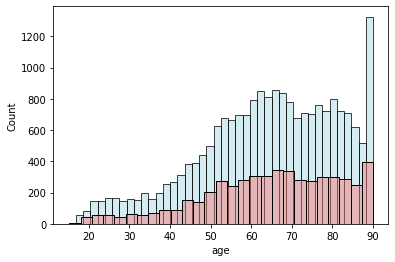

In [ ]:
sns.histplot(data=df, x="age", color="lightblue", alpha=0.5)
sns.histplot(data=df_test, x="age", color="lightcoral", alpha=0.5)

### Religion
I use the largest religious groups in the dataset for the creation of my dummy variables and group all remaining religions in an 'Other' category. 'Unobtainable' and 'Not specified' are grouped together. The following dummies will be created: Catholic, Protestant, Jewish, Not Specified, Other.

In [ ]:
df['RELIGION'].replace({"UNOBTAINABLE": "NOT SPECIFIED", "PROTESTANT QUAKER": "PROTESTANT", "HEBREW": "JEWISH"}, inplace=True)
df_test['RELIGION'].replace({"UNOBTAINABLE": "NOT SPECIFIED", "PROTESTANT QUAKER": "PROTESTANT", "HEBREW": "JEWISH"}, inplace=True)

religion_other = ["EPISCOPALIAN",
                  "GREEK ORTHODOX",
                  "CHRISTIAN SCIENTIST",
                  "BUDDHIST",
                  "MUSLIM",
                  "UNITARIAN-UNIVERSALIST",
                  "JEHOVAH'S WITNESS",
                  "HINDU",
                  "ROMANIAN EAST. ORTH",
                  "7TH DAY ADVENTIST"]

for religion in religion_other:
    df['RELIGION'].replace({religion: "OTHER"}, inplace=True)
    df_test['RELIGION'].replace({religion: "OTHER"}, inplace=True)

df['RELIGION'].value_counts()
df_test['RELIGION'].value_counts()

CATHOLIC         1898
NOT SPECIFIED    1756
PROTESTANT        697
JEWISH            446
OTHER             424
Name: RELIGION, dtype: int64

### Ethnicity
I merge ethnicities into the "main" ethnic groups. These include: White, Black, Hispanic and Asian.
All other ethnic groups are put into an 'Other' column unless the ethnicity is not specified.

In [ ]:
for my_df in [df, df_test]:
    my_df.loc[my_df['ETHNICITY'].str.contains('WHITE', case=False), 'ETHNICITY'] = 'WHITE'
    my_df.loc[my_df['ETHNICITY'].str.contains('HISPANIC', case=False), 'ETHNICITY'] = 'HISPANIC'
    my_df.loc[my_df['ETHNICITY'].str.contains('ASIAN', case=False), 'ETHNICITY'] = 'ASIAN'
    my_df.loc[my_df['ETHNICITY'].str.contains('BLACK', case=False), 'ETHNICITY'] = 'BLACK'

    my_df['ETHNICITY'].replace({'PORTUGUESE': "WHITE"}, inplace=True)

    unknowns = ['UNABLE TO OBTAIN', 'UNKNOWN/NOT SPECIFIED', 'PATIENT DECLINED TO ANSWER']
    for unknown in unknowns:
        my_df['ETHNICITY'].replace({unknown: "UNKNOWN/NOT SPECIFIED"}, inplace=True)

    ethnicity_other = ['MULTI RACE ETHNICITY',
                      'MIDDLE EASTERN', 
                      'AMERICAN INDIAN/ALASKA NATIVE',
                      'CARIBBEAN ISLAND',
                      'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER',
                      'SOUTH AMERICAN',
                      'AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE']
    for ethnicity in ethnicity_other:
        my_df['ETHNICITY'].replace({ethnicity: "OTHER"}, inplace=True)
    
df['ETHNICITY'].value_counts()
df_test['ETHNICITY'].value_counts()

WHITE                    3866
BLACK                     532
UNKNOWN/NOT SPECIFIED     352
HISPANIC                  203
ASIAN                     144
OTHER                     124
Name: ETHNICITY, dtype: int64

### Repeat Visits to the ICU
Some patients visit the ICU more than once. I capture this in a variable.

In [ ]:
df['visits_ICU'] = df.sort_values(['subject_id', 'ADMITTIME']).groupby(['subject_id']).cumcount()
df_test['visits_ICU'] = df_test.sort_values(['subject_id', 'ADMITTIME']).groupby(['subject_id']).cumcount()

In [ ]:
df[["subject_id", "ADMITTIME", "visits_ICU"]].sort_values(["subject_id", "ADMITTIME"]).iloc[:13]
df_test[["subject_id", "ADMITTIME", "visits_ICU"]].sort_values(["subject_id", "ADMITTIME"]).iloc[:13]

subject_id   ADMITTIME  visits_ICU
1763         107  2011-07-01           0
2871         107  2011-12-13           1
2929         109  2008-05-18           0
125          109  2008-11-24           1
4617         109  2008-12-15           2
569          109  2009-04-26           3
1170         154  2011-07-11           0
3654         188  2011-05-12           0
3997         236  2009-01-08           0
2423         249  2009-09-17           0
3371         249  2009-09-17           1
2534         256  2008-07-20           0
3976         266  2010-08-30           0

In [ ]:
# Delete 'ADMITTIME'
df = df.drop(columns=['ADMITTIME'])
df_test = df_test.drop(columns=['ADMITTIME'])

### Diagnoses
I remove the text fields as these contain the same information as the ICD9 codes.

In [ ]:
df = df.drop(['DIAGNOSIS'], axis = 1)
df_test = df_test.drop(['DIAGNOSIS'], axis = 1)

### Group ICD9 codes into parent categories
ICD9 is a classification system used for the classification of diseases and health disorders. Each ICD9 codes consist of a 3 digit number with two decimal places. The three digit code specifies a specific disease, with the decimal places giving information as to the severity of the diagnosis. Each health disorder can be placed into one of the chapters below, which give a grouping of diseases into parent categories: 
+ 001–139	Infectious and Parasitic Diseases
+ 140–239	Neoplasms
+ 240–279	Endocrine, Nutritional and Metabolic Diseases, and Immunity Disorders
+ 280–289	Diseases of the Blood and Blood-forming Organs
+ 290–319	Mental Disorders
+ 320–389	Diseases of the Nervous System and Sense Organs
+ 390–459	Diseases of the Circulatory System
+ 460–519	Diseases of the Respiratory System
+ 520–579	Diseases of the Digestive System
+ 580–629	Diseases of the Genitourinary System
+ 630–679	Complications of Pregnancy, Childbirth, and the Puerperium
+ 680–709	Diseases of the Skin and Subcutaneous Tissue
+ 710–739	Diseases of the Musculoskeletal System and Connective Tissue
+ 740–759	Congenital Anomalies
+ 760–779	Certain Conditions originating in the Perinatal Period
+ 780–799	Symptoms, Signs and Ill-defined Conditions
+ 800–999	Injury and Poisoning
+ E800–E999	Supplementary Classification of External Causes of Injury and Poisoning
+ V01–V82	Supplementary Classification of Factors influencing Health Status and Contact with Health Services

This grouping will be used to dilute the comorbidity information by constructing parent categories for the ICD9 codes in the comorbidity data. Supplementary Classifications starting with E and V are grouped together into one category.

In [ ]:
for my_df in [df, df_test]:
  my_df['icd9_group'] = my_df['ICD9_diagnosis']

  my_df['icd9_group'] = my_df['icd9_group'].str[:3]
  my_df.loc[my_df['icd9_group'].str.startswith('V'), 'icd9_group'] = '000'
  my_df.loc[my_df['icd9_group'].str.startswith('E'), 'icd9_group'] = '000'

  my_df['icd9_group'] = my_df['icd9_group'].astype(int)

  # Make ICD9 classifications
  bins= [-1, 1, 140, 240, 280, 290, 320, 390, 460, 520, 580, 630, 680, 710, 740, 760, 780, 800, 1000]
  labels = ['Supplementary Classification',
          'Infectious and Parasitic',
          'Neoplams',
          'Endocrine',
          'Blood',
          'Mental',
          'Nervous System',
          'Circulatory System',
          'Respiratory System',
          'Digestive System',
          'Genitourinary System',
          'Pregnancy',
          'Skin',
          'Muscoskeletal System',
          'Congenital Anomalies',
          'Perinatal',
          'Ill-defined',
          'Injury and Poisoning']

  my_df['icd9_group'] = pd.cut(my_df['icd9_group'], bins=bins, labels=labels, right=False)

print(df.loc[:,['ICD9_diagnosis', 'icd9_group']].head(10))
print(df_test.loc[:,['ICD9_diagnosis', 'icd9_group']].head(10))

df = df.drop(columns=['ICD9_diagnosis'])
df_test = df_test.drop(columns=['ICD9_diagnosis'])

  ICD9_diagnosis          icd9_group
0           5789    Digestive System
1          53013    Digestive System
2          56983    Digestive System
3           5533    Digestive System
4          56211    Digestive System
5           5550    Digestive System
6           5513    Digestive System
7           1625            Neoplams
8          49322  Respiratory System
9          41511  Circulatory System
  ICD9_diagnosis            icd9_group
0           4241    Circulatory System
1          25013             Endocrine
2           5920  Genitourinary System
3          82120  Injury and Poisoning
4          51884    Respiratory System
5           3071                Mental
6          85186  Injury and Poisoning
7           1541              Neoplams
8          80629  Injury and Poisoning
9           4241    Circulatory System


### Drop all remaining unnecessary columns

In [ ]:
# Drop id columns
df = df.drop(columns=['subject_id', 'hadm_id', 'icustay_id'])
df_test = df_test.drop(columns=['subject_id', 'hadm_id', 'icustay_id'])
print(df.columns)
print(df_test.columns)

Index(['HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min',
       'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean',
       'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min',
       'RespRate_Max', 'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean',
       'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max',
       'Glucose_Mean', 'GENDER', 'ADMISSION_TYPE', 'INSURANCE', 'RELIGION',
       'MARITAL_STATUS', 'ETHNICITY', 'FIRST_CAREUNIT', 'LOS',
       'comorbidity_count', 'LOS_mean', 'LOS_median', 'LOS_min', 'LOS_max',
       'age', 'visits_ICU', 'icd9_group'],
      dtype='object')
Index(['HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min',
       'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean',
       'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min',
       'RespRate_Max', 'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean',
       'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'Glucose_Min

### Look at associations between categorical features and the outcome variable.

In [ ]:
cat_feat_selected = ['GENDER', 'ADMISSION_TYPE', 'INSURANCE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY', 'FIRST_CAREUNIT']
print(cat_feat_selected)

['GENDER', 'ADMISSION_TYPE', 'INSURANCE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY', 'FIRST_CAREUNIT']


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
Creating an ndarray from ragged nested seque

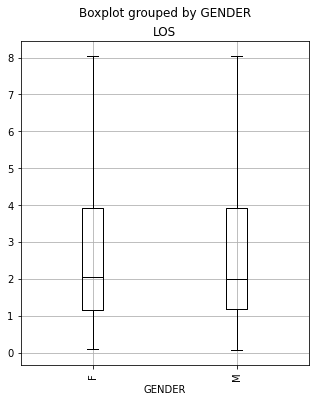

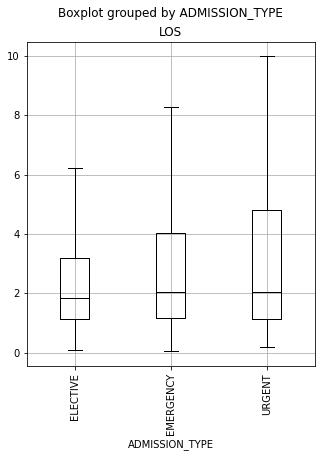

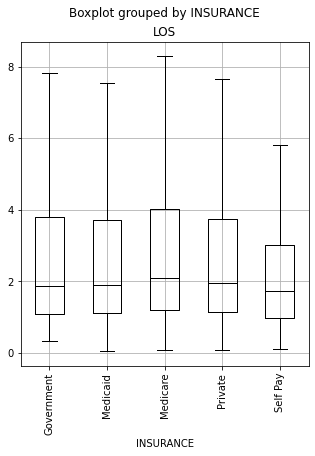

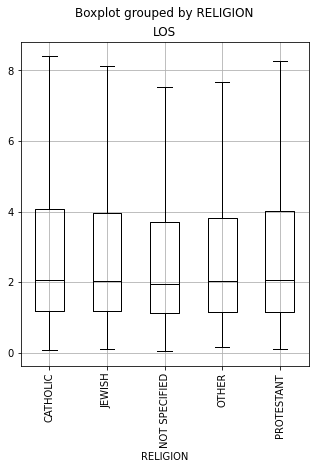

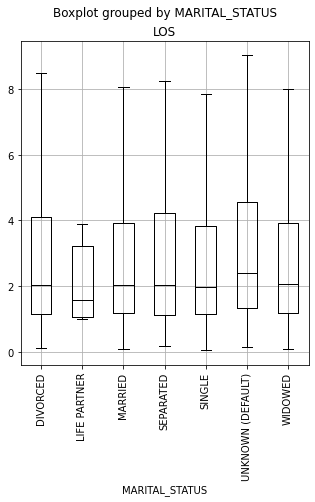

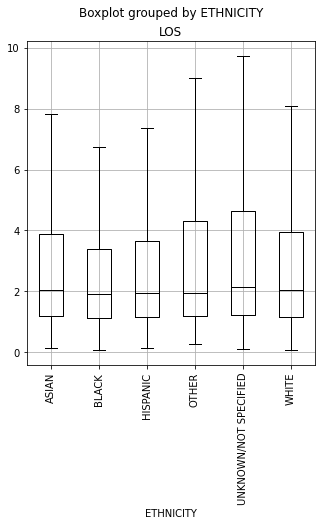

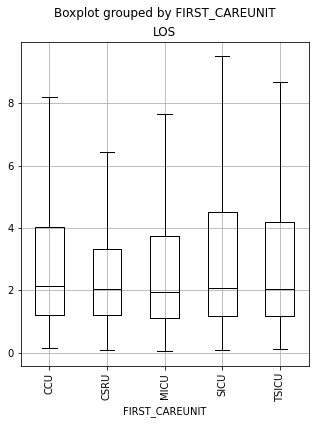

In [ ]:
for feat in cat_feat_selected:
  df.boxplot('LOS', feat, rot = 90,figsize=(5,6), showfliers=False, color="black");

The following conclusions can be drawn regarding the associations between the categorical features and the outcome variable *LOS*:
+ Gender: there are no significant differences in the distribution of *LOS* across gender.
+ Admission type: the median *LOS* is the same across all admission types, but the upper quartile and max *LOS* are slightly higher for urgent admissions.
+ Insurance: individuals who self-pay have a slightly lower median *LOS*; the max *LOS* is highest for Government insurance and Medicare.
+ Religion: there are no significant differences in the distribution of *LOS* across religion; the categories "not speficied" and "other" have a slightly lower upper quartile and max *LOS*.
+ Marital Status: individuals with a life-partner have the lowest *LOS* (is there confounding with age?)
+ Ethnicity: the groups "Black" and "Hispanic" feature the shortest stay in hospital.
+ First Care Unit: the category "CSRU" features a lower upper quartile and maximum, whilst the category "SICU" has a higher upper quartile and maximum *LOS*.

There are some differences in *LOS* between different categories. However, the differences are relatively small, so it is unlikely that any of these features will be important for accurately predicting *LOS*.

## Preprocessing
Initially, I wanted to set up a preprocessing pipeline. Unfortunately, I lost the feature names in the process. I will thus manually preprocess the data. I have kept the code for setting up the preprocessing pipeline as this yields a nice depiction of how each group of features is manipulated.

In [ ]:
# Update list of numerical and categorical features
num_feat_clean = df.select_dtypes(exclude=['object', 'category']).columns
num_feat_clean = num_feat_clean.drop(['LOS'])
print(num_feat_clean)

cat_feat_clean = df.select_dtypes(include=['object', 'category']).columns
print(cat_feat_clean)

# make own category for preprocessing 'ICD9_diagnosis'
icd9_feat_clean = ['icd9_group']
cat_feat_clean = cat_feat_clean.drop(['icd9_group']) 
print(icd9_feat_clean)
print(cat_feat_clean)

Index(['HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min',
       'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean',
       'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min',
       'RespRate_Max', 'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean',
       'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max',
       'Glucose_Mean', 'comorbidity_count', 'LOS_mean', 'LOS_median',
       'LOS_min', 'LOS_max', 'age', 'visits_ICU'],
      dtype='object')
Index(['GENDER', 'ADMISSION_TYPE', 'INSURANCE', 'RELIGION', 'MARITAL_STATUS',
       'ETHNICITY', 'FIRST_CAREUNIT', 'icd9_group'],
      dtype='object')
['icd9_group']
Index(['GENDER', 'ADMISSION_TYPE', 'INSURANCE', 'RELIGION', 'MARITAL_STATUS',
       'ETHNICITY', 'FIRST_CAREUNIT'],
      dtype='object')


In [ ]:
# pipeline for numerical data
num_preprocessing = make_pipeline(
    RobustScaler(),
    SimpleImputer(strategy="mean"))

# pipeline for categorical data
cat_preprocessing = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore", sparse=False),
    StandardScaler())

icd9_preprocessing = make_pipeline(
    #ce.BinaryEncoder(),
    #ce.TargetEncoder(smoothing = 1.0),
    OneHotEncoder(handle_unknown="ignore", sparse=False), # if onehotencoding by organ system or top comorbidities
    StandardScaler())


# combine preprocessing pipelines using a columnTransformer
preprocessing= ColumnTransformer(
    [("num", num_preprocessing, num_feat_clean),
     ("cat", cat_preprocessing, cat_feat_clean),
     ("icd9", icd9_preprocessing, icd9_feat_clean)],
     remainder='passthrough'
)

In [ ]:
from sklearn import set_config
set_config(display="diagram")
preprocessing

ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('robustscaler',
                                                  RobustScaler()),
                                                 ('simpleimputer',
                                                  SimpleImputer())]),
                                 Index(['HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min',
       'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean',
       'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min',
       'RespRate_Max',...
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False)),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['GENDER', 'ADMISSION_TYPE', 'INSURANCE', 'RELIGION', 'MARITAL_STATUS',
       'ETHNICITY', 'FIRST_CAREUNIT'],
      dtype='object')),
                                ('icd9',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False)),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['icd9_group'])])

In [ ]:
## preprocess numerical features
# scale data
scaler_num = RobustScaler()
scaler_num.fit(df[num_feat_clean])

df[num_feat_clean] = scaler_num.transform(df[num_feat_clean])
df_test[num_feat_clean] = scaler_num.transform(df_test[num_feat_clean])


# impute missing values
imputer_num = SimpleImputer(strategy="mean")
imputer_num.fit(df[num_feat_clean])

df[num_feat_clean] = imputer_num.transform(df[num_feat_clean])
df_test[num_feat_clean] = imputer_num.transform(df_test[num_feat_clean])


# check that preprocessing worked
df[num_feat_clean].describe()
#df[num_feat_clean].isnull().sum().sort_values()

HeartRate_Min  HeartRate_Max  HeartRate_Mean     SysBP_Min  \
count   20885.000000   20885.000000    20885.000000  20885.000000   
mean        0.037153       0.079993        0.050164      0.055528   
std         0.740512       0.707029        0.693065      0.828991   
min        -3.526316      -2.285714       -2.362991     -4.250000   
25%        -0.421053      -0.392857       -0.409533     -0.400000   
50%         0.037153       0.079993        0.050164      0.055528   
75%         0.473684       0.464286        0.453065      0.500000   
max         3.789474       6.321429        3.813147      4.550000   

          SysBP_Max    SysBP_Mean    DiasBP_Min    DiasBP_Max   DiasBP_Mean  \
count  20885.000000  20885.000000  20885.000000  20885.000000  20885.000000   
mean       0.090864      0.100311      0.023418      0.102643      0.077691   
std        0.751289      0.706187      0.804455      0.792917      0.743537   
min       -3.400000     -3.170203     -2.857143     -2.565217     -3.172304   
25%       -0.400000     -0.387596     -0.428571     -0.434783     -0.405157   
50%        0.090864      0.100311      0.023418      0.086957      0.077691   
75%        0.466667      0.479584      0.428571      0.434783      0.455336   
max        5.833333      3.812654      4.357143      9.043478      4.289306   

         MeanBP_Min  ...   Glucose_Min   Glucose_Max  Glucose_Mean  \
count  20885.000000  ...  20885.000000  20885.000000  20885.000000   
mean      -0.047129  ...      0.136628      0.264120      0.232491   
std        0.905137  ...      0.999002      1.151282      1.018973   
min       -3.733333  ...     -2.857143     -1.487500     -1.977401   
25%       -0.466667  ...     -0.428571     -0.425000     -0.403086   
50%       -0.047129  ...      0.000000      0.000000      0.007605   
75%        0.400000  ...      0.542857      0.550000      0.580291   
max        4.333333  ...     13.171429     28.487500     14.676119   

       comorbidity_count      LOS_mean    LOS_median       LOS_min  \
count       20885.000000  20885.000000  20885.000000  20885.000000   
mean            0.083811      0.175194      0.224176     -0.219323   
std             0.730129      0.939367      0.915706      0.742309   
min            -1.300000     -2.866730     -4.193516     -4.218476   
25%            -0.500000     -0.422348     -0.369861     -0.647894   
50%             0.000000      0.000000      0.000000      0.000000   
75%             0.500000      0.577652      0.630139      0.352106   
max             2.500000     21.973451     21.255005      9.447203   

            LOS_max           age    visits_ICU  
count  20885.000000  20885.000000  20885.000000  
mean       0.319064     -0.059610      0.395547  
std        1.501247      0.692841      1.118684  
min       -1.557644     -2.047856      0.000000  
25%       -0.481976     -0.500055      0.000000  
50%        0.000000      0.000000      0.000000  
75%        0.518024      0.499945      0.000000  
max       53.787944      0.984657     24.000000  

[8 rows x 31 columns]

In [ ]:
## preprocess categorical features
# impute missing values
imputer_cat = SimpleImputer(strategy="most_frequent")
imputer_cat.fit(df[cat_feat_clean])

df[cat_feat_clean] = imputer_cat.transform(df[cat_feat_clean])
df_test[cat_feat_clean] = imputer_cat.transform(df_test[cat_feat_clean])


# get dummies
df = pd.get_dummies(df, columns = cat_feat_clean, drop_first=True)
df_test = pd.get_dummies(df_test, columns = cat_feat_clean, drop_first=True)

In [ ]:
# update list of categorical features
cat_feat_dummies = ['GENDER_M', 'ADMISSION_TYPE_EMERGENCY', 'ADMISSION_TYPE_URGENT', 'INSURANCE_Medicaid',
                'INSURANCE_Medicare','INSURANCE_Private', 'INSURANCE_Self Pay', 'RELIGION_JEWISH',
                'RELIGION_NOT SPECIFIED', 'RELIGION_OTHER', 'RELIGION_PROTESTANT','MARITAL_STATUS_LIFE PARTNER',
                'MARITAL_STATUS_MARRIED','MARITAL_STATUS_SEPARATED', 'MARITAL_STATUS_SINGLE',
                'MARITAL_STATUS_UNKNOWN (DEFAULT)', 'MARITAL_STATUS_WIDOWED', 'ETHNICITY_BLACK',
                'ETHNICITY_HISPANIC', 'ETHNICITY_OTHER','ETHNICITY_UNKNOWN/NOT SPECIFIED', 'ETHNICITY_WHITE',
                'FIRST_CAREUNIT_CSRU', 'FIRST_CAREUNIT_MICU', 'FIRST_CAREUNIT_SICU', 'FIRST_CAREUNIT_TSICU']

# scale data
scaler_cat = StandardScaler()
scaler_cat.fit(df[cat_feat_dummies])

df[cat_feat_dummies] = scaler_cat.transform(df[cat_feat_dummies])
df_test[cat_feat_dummies] = scaler_cat.transform(df_test[cat_feat_dummies])


# check that preprocessing worked
df[cat_feat_dummies].describe()
#df[cat_feat_dummies].isnull().sum().sort_values()

GENDER_M  ADMISSION_TYPE_EMERGENCY  ADMISSION_TYPE_URGENT  \
count  2.088500e+04              2.088500e+04           2.088500e+04   
mean  -3.184854e-16             -2.092588e-15          -1.647792e-17   
std    1.000024e+00              1.000024e+00           1.000024e+00   
min   -1.135128e+00             -2.409848e+00          -1.031796e-01   
25%   -1.135128e+00              4.149640e-01          -1.031796e-01   
50%    8.809577e-01              4.149640e-01          -1.031796e-01   
75%    8.809577e-01              4.149640e-01          -1.031796e-01   
max    8.809577e-01              4.149640e-01           9.691843e+00   

       INSURANCE_Medicaid  INSURANCE_Medicare  INSURANCE_Private  \
count        2.088500e+04        2.088500e+04       2.088500e+04   
mean         1.447197e-15       -8.323191e-16      -9.170968e-16   
std          1.000024e+00        1.000024e+00       1.000024e+00   
min         -3.358547e-01       -1.130611e+00      -6.531241e-01   
25%         -3.358547e-01       -1.130611e+00      -6.531241e-01   
50%         -3.358547e-01        8.844777e-01      -6.531241e-01   
75%         -3.358547e-01        8.844777e-01       1.531103e+00   
max          2.977478e+00        8.844777e-01       1.531103e+00   

       INSURANCE_Self Pay  RELIGION_JEWISH  RELIGION_NOT SPECIFIED  \
count        2.088500e+04     2.088500e+04            2.088500e+04   
mean        -1.042041e-15    -2.200092e-15            3.471381e-16   
std          1.000024e+00     1.000024e+00            1.000024e+00   
min         -9.683004e-02    -3.109194e-01           -7.034026e-01   
25%         -9.683004e-02    -3.109194e-01           -7.034026e-01   
50%         -9.683004e-02    -3.109194e-01           -7.034026e-01   
75%         -9.683004e-02    -3.109194e-01            1.421661e+00   
max          1.032737e+01     3.216268e+00            1.421661e+00   

       RELIGION_OTHER  ...  MARITAL_STATUS_WIDOWED  ETHNICITY_BLACK  \
count    2.088500e+04  ...            2.088500e+04     2.088500e+04   
mean    -9.334751e-16  ...            1.107294e-15     7.504066e-16   
std      1.000024e+00  ...            1.000024e+00     1.000024e+00   
min     -2.998625e-01  ...           -3.950177e-01    -3.432220e-01   
25%     -2.998625e-01  ...           -3.950177e-01    -3.432220e-01   
50%     -2.998625e-01  ...           -3.950177e-01    -3.432220e-01   
75%     -2.998625e-01  ...           -3.950177e-01    -3.432220e-01   
max      3.334861e+00  ...            2.531532e+00     2.913566e+00   

       ETHNICITY_HISPANIC  ETHNICITY_OTHER  ETHNICITY_UNKNOWN/NOT SPECIFIED  \
count        2.088500e+04     2.088500e+04                     2.088500e+04   
mean        -3.226743e-16    -4.981252e-17                    -1.038389e-15   
std          1.000024e+00     1.000024e+00                     1.000024e+00   
min         -2.062276e-01    -1.715408e-01                    -2.597449e-01   
25%         -2.062276e-01    -1.715408e-01                    -2.597449e-01   
50%         -2.062276e-01    -1.715408e-01                    -2.597449e-01   
75%         -2.062276e-01    -1.715408e-01                    -2.597449e-01   
max          4.849011e+00     5.829515e+00                     3.849931e+00   

       ETHNICITY_WHITE  FIRST_CAREUNIT_CSRU  FIRST_CAREUNIT_MICU  \
count     2.088500e+04         2.088500e+04         2.088500e+04   
mean      9.952510e-16         3.631017e-16        -4.586547e-17   
std       1.000024e+00         1.000024e+00         1.000024e+00   
min      -1.669414e+00        -4.196304e-01        -8.399965e-01   
25%      -1.669414e+00        -4.196304e-01        -8.399965e-01   
50%       5.990124e-01        -4.196304e-01        -8.399965e-01   
75%       5.990124e-01        -4.196304e-01         1.190481e+00   
max       5.990124e-01         2.383050e+00         1.190481e+00   

       FIRST_CAREUNIT_SICU  FIRST_CAREUNIT_TSICU  
count         2.088500e+04          2.088500e+04  
mean          3.535012e-16         -3.131589e-17  


In [ ]:
## preprocess ICD9 codes
# get dummies
df = pd.get_dummies(df, columns = icd9_feat_clean, drop_first=True)
df_test = pd.get_dummies(df_test, columns = icd9_feat_clean, drop_first=True)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20885 entries, 0 to 20884
Data columns (total 75 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   HeartRate_Min                        20885 non-null  float64
 1   HeartRate_Max                        20885 non-null  float64
 2   HeartRate_Mean                       20885 non-null  float64
 3   SysBP_Min                            20885 non-null  float64
 4   SysBP_Max                            20885 non-null  float64
 5   SysBP_Mean                           20885 non-null  float64
 6   DiasBP_Min                           20885 non-null  float64
 7   DiasBP_Max                           20885 non-null  float64
 8   DiasBP_Mean                          20885 non-null  float64
 9   MeanBP_Min                           20885 non-null  float64
 10  MeanBP_Max                           20885 non-null  float64
 11  MeanBP_Mean                 

In [ ]:
# update list of icd9 features
icd9_feat_dummies = [col for col in df.columns if 'icd9_group' in col]
icd9_feat_dummies

['icd9_group_Infectious and Parasitic',
 'icd9_group_Neoplams',
 'icd9_group_Endocrine',
 'icd9_group_Blood',
 'icd9_group_Mental',
 'icd9_group_Nervous System',
 'icd9_group_Circulatory System',
 'icd9_group_Respiratory System',
 'icd9_group_Digestive System',
 'icd9_group_Genitourinary System',
 'icd9_group_Pregnancy',
 'icd9_group_Skin',
 'icd9_group_Muscoskeletal System',
 'icd9_group_Congenital Anomalies',
 'icd9_group_Perinatal',
 'icd9_group_Ill-defined',
 'icd9_group_Injury and Poisoning']

In [ ]:
# scale data
scaler_icd9 = StandardScaler()
scaler_icd9.fit(df[icd9_feat_dummies])

df[icd9_feat_dummies] = scaler_icd9.transform(df[icd9_feat_dummies])
df_test[icd9_feat_dummies] = scaler_icd9.transform(df_test[icd9_feat_dummies])

In [ ]:
df.head()
df_test.head()

HeartRate_Min  HeartRate_Max  HeartRate_Mean  SysBP_Min  SysBP_Max  \
0      -0.578947      -0.464286        0.053255      -0.65   0.166667   
1       1.157895       1.500000        1.478725      -0.85  -0.166667   
2       1.947368       1.035714        1.607567       0.15  -0.366667   
3       0.157895       0.071429       -0.024103      -0.90   0.666667   
4       0.842105       0.750000        0.691862      -0.20  -0.133333   

   SysBP_Mean  DiasBP_Min  DiasBP_Max  DiasBP_Mean  MeanBP_Min  ...  \
0   -0.823204   -0.285714   -0.391304    -0.671647   -0.266667  ...   
1   -0.701603   -0.142857    0.000000     0.296730   -0.466667  ...   
2   -0.030393    0.500000   -0.434783     0.377049    0.200000  ...   
3    0.450696   -0.357143    0.565217     0.102180   -0.733333  ...   
4   -0.278796    0.571429    2.043478     0.814768    0.600000  ...   

   icd9_group_Respiratory System  icd9_group_Digestive System  \
0                      -0.320729                    -0.355474   
1                      -0.320729                    -0.355474   
2                      -0.320729                    -0.355474   
3                      -0.320729                    -0.355474   
4                       3.117892                    -0.355474   

   icd9_group_Genitourinary System  icd9_group_Pregnancy  icd9_group_Skin  \
0                        -0.147889             -0.046983        -0.063547   
1                        -0.147889             -0.046983        -0.063547   
2                         6.761848             -0.046983        -0.063547   
3                        -0.147889             -0.046983        -0.063547   
4                        -0.147889             -0.046983        -0.063547   

   icd9_group_Muscoskeletal System  icd9_group_Congenital Anomalies  \
0                        -0.124939                        -0.064677   
1                        -0.124939                        -0.064677   
2                        -0.124939                        -0.064677   
3                        -0.124939                        -0.064677   
4                        -0.124939                        -0.064677   

   icd9_group_Perinatal  icd9_group_Ill-defined  \
0                   0.0               -0.108273   
1                   0.0               -0.108273   
2                   0.0               -0.108273   
3                   0.0               -0.108273   
4                   0.0               -0.108273   

   icd9_group_Injury and Poisoning  
0                        -0.438874  
1                        -0.438874  
2                        -0.438874  
3                         2.278556  
4                        -0.438874  

[5 rows x 74 columns]

In [ ]:
X_train, y_train = df.drop(columns=['LOS']), df['LOS']
X_test = df_test

In [ ]:
y_train.describe()

count    20885.000000
mean         3.701046
std          5.175721
min          0.056600
25%          1.165400
50%          2.020800
75%          3.915800
max        101.739000
Name: LOS, dtype: float64

In [ ]:
'''
# fit ColumnTransformer to preprocess the data
preprocessing.fit(X_train, y_train)
X_train = preprocessing.transform(X_train)
X_test = preprocessing.transform(X_test)
'''

## Simple Decision Tree Regressor
I fit a simple decision tree to have a baseline model to which compare all subsequent models too. The number of leaf nodes is limited to 20 to prevent the tree from going all the way to the end and perfectly fitting the training data.

In [ ]:
%%time

dt_simple = DecisionTreeRegressor(max_leaf_nodes=20)
dt_simple.fit(X_train, y_train)

y_pred_train_dt_simple = dt_simple.predict(X_train)
y_pred_test_dt_simple = dt_simple.predict(X_test)

print('RMSE : ' + str(sqrt(mean_squared_error(y_train, y_pred_train_dt_simple))))
print('R-squared : ' + str(r2_score(y_train, y_pred_train_dt_simple)))

RMSE : 3.8553386697287215
R-squared : 0.44511357485811043
CPU times: user 241 ms, sys: 1.94 ms, total: 243 ms
Wall time: 245 ms


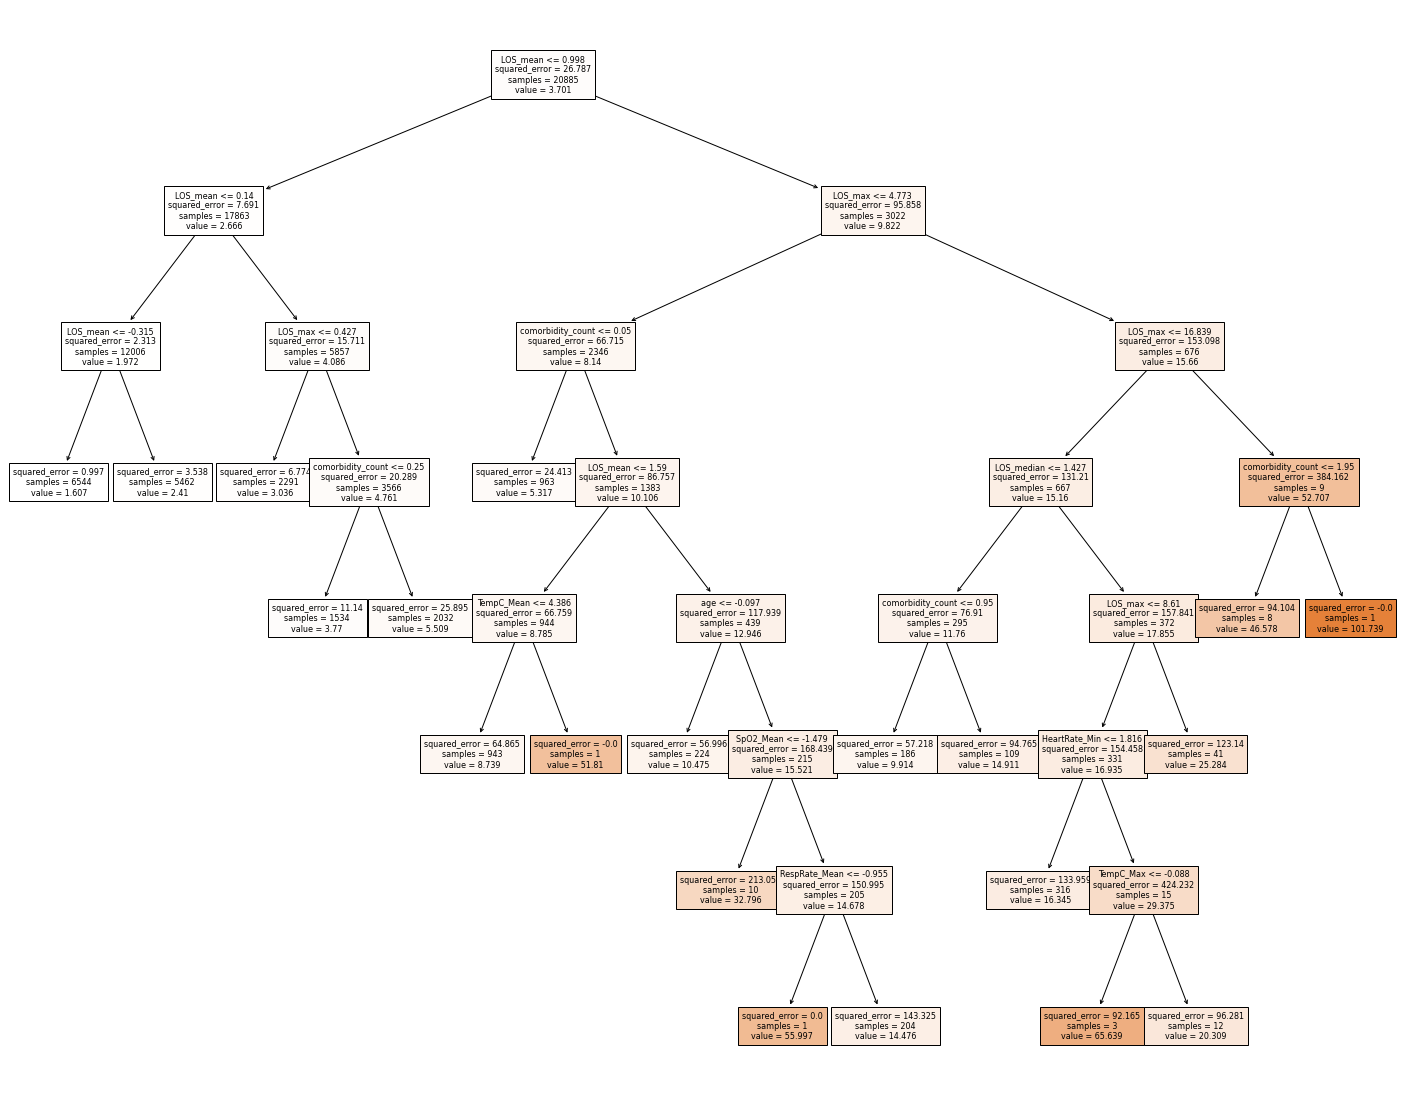

In [ ]:
# plot the tree
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(dt_simple, feature_names=X_train.columns, filled=True, fontsize=8)

In [ ]:
# Produce .csv for kaggle testing 
test_predictions_submit = pd.DataFrame({"icustay_id": data_test["icustay_id"], "LOS": y_pred_test_dt_simple})
test_predictions_submit.to_csv("kaggle/test_predictions_submit_dt_simple.csv", index = False)

## Simple Random Forest Regressor
I do the same with a simple random forest model to show that just by making an ensemble of decision trees, we can increase the perfomance of our model whilst also reducing the risk of overfitting. The RMSE decreases from 4.098 to 1.618. When uploading this model to kaggle, I only obtain a score of 4.40. This indicates that using the Random Forest has not prevented me from overfitting to the training data. The out-of-sample performance is much worse.

In [ ]:
%%time

rf_simple = RandomForestRegressor(n_estimators=50)
rf_simple.fit(X_train, y_train)

y_pred_train_rf_simple = rf_simple.predict(X_train)
y_pred_test_rf_simple = rf_simple.predict(X_test)

print('RMSE : ' + str(sqrt(mean_squared_error(y_train, y_pred_train_rf_simple))))
print('R-squared : ' + str(r2_score(y_train, y_pred_train_rf_simple)))

RMSE : 1.523237951149711
R-squared : 0.913380726956383
CPU times: user 32.4 s, sys: 98.4 ms, total: 32.5 s
Wall time: 32.8 s


The RMSE is super low and the R-squared is close to 1. This indicates that my simple RandomForest is drastically overfitting to the training data.

In [ ]:
# Produce .csv for kaggle testing 
test_predictions_submit = pd.DataFrame({"icustay_id": data_test["icustay_id"], "LOS": y_pred_test_rf_simple})
test_predictions_submit.to_csv("kaggle/test_predictions_submit_rf_simple.csv", index = False)

## Hyperparameter Optimisation and Boosting
After having fitted a simple baseline model for Decision Trees and Random Forests respectively, I try different boosting methods and contrast these with the performance of the previous two models. I perform hyperparameter optimization before I compare the in-sample performance.

In [ ]:
%%time

# models
models = [DecisionTreeRegressor(),
          RandomForestRegressor(),
          XGBRegressor(),
          AdaBoostRegressor(),
          GradientBoostingRegressor()]

# models parameters
dt_params = {'max_features': range(4, 10),
             'max_depth': range(3, 6),
             'min_samples_leaf': range(5, 10),
             'random_state': [SEED]}

rf_params = {'max_features': range(4, 10),
             'n_estimators': [50, 100],
             'max_depth': range(3, 6),
             'min_samples_leaf': range(5, 10),
             'random_state': [SEED]}

xgb_params = {'objective':['reg:squarederror'],
              'learning_rate': [0.05, 1],
              'max_depth': range(3, 10),
              'min_child_weight': range(5, 10),
              'reg_lambda':[1.5],
              'seed': [SEED]}

ada_params = {'learning_rate': [0.05, 1],
              'n_estimators': [50, 100],
              'loss':['linear', 'square'],
              'random_state': [SEED]}

gbm_params = {'learning_rate': [0.05, 1],
              'n_estimators': [50, 100],
              'max_depth': range(3, 6),
              'max_features': range(4, 10),
              'random_state': [SEED]}

params = [dt_params, rf_params, xgb_params, ada_params, gbm_params]
names = ['DecisionTree', 'RandomForest', 'XGB', 'ADA', 'GBM']

scores_boost = {}

# gridsearch
for i, model in enumerate(models):
    print(f"Grid-Searching for model {names[i]}...")
    
    best_model = RandomizedSearchCV(model, params[i], n_jobs=4, cv=5, scoring='neg_mean_squared_error', verbose = 0)
    best_model.fit(X_train, y_train)
    
    print(f"Best model fitted")
    
    # assign the best parameters to my models
    models[i].set_params(**best_model.best_params_)
    scores_boost[names[i]] = (best_model.best_estimator_, sqrt(-best_model.best_score_))
    
    # print scores (on LOS)
    print(f'{names[i]} chosen hyperparameters: {best_model.best_params_}')
    print(f'{names[i]} in-sample RMSE: {sqrt(-best_model.best_score_)}')

Grid-Searching for model DecisionTree...
Best model fitted
DecisionTree chosen hyperparameters: {'random_state': 42, 'min_samples_leaf': 7, 'max_features': 8, 'max_depth': 5}
DecisionTree in-sample RMSE: 4.371995720994118
Grid-Searching for model RandomForest...
Best model fitted
RandomForest chosen hyperparameters: {'random_state': 42, 'n_estimators': 100, 'min_samples_leaf': 8, 'max_features': 9, 'max_depth': 5}
RandomForest in-sample RMSE: 4.160603121723442
Grid-Searching for model XGB...
Best model fitted
XGB chosen hyperparameters: {'seed': 42, 'reg_lambda': 1.5, 'objective': 'reg:squarederror', 'min_child_weight': 8, 'max_depth': 5, 'learning_rate': 0.05}
XGB in-sample RMSE: 3.839403758227054
Grid-Searching for model ADA...


The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.


Best model fitted
ADA chosen hyperparameters: {'random_state': 42, 'n_estimators': 50, 'loss': 'linear', 'learning_rate': 0.05}
ADA in-sample RMSE: 4.12528253896925
Grid-Searching for model GBM...
Best model fitted
GBM chosen hyperparameters: {'random_state': 42, 'n_estimators': 100, 'max_features': 7, 'max_depth': 4, 'learning_rate': 0.05}
GBM in-sample RMSE: 3.9397028630818074
CPU times: user 25.1 s, sys: 522 ms, total: 25.7 s
Wall time: 11min 2s


In [ ]:
ranking_boost = pd.DataFrame.from_dict(scores_boost, orient='index').reset_index()
ranking_boost.columns = ['Model', 'Setting', 'RMSE']

ranking_boost.head()

Model                                            Setting      RMSE
0  DecisionTree  DecisionTreeRegressor(max_depth=5, max_feature...  4.371996
1  RandomForest  (DecisionTreeRegressor(max_depth=5, max_featur...  4.160603
2           XGB  XGBRegressor(learning_rate=0.05, max_depth=5, ...  3.839404
3           ADA  (DecisionTreeRegressor(max_depth=3, random_sta...  4.125283
4           GBM  ([DecisionTreeRegressor(criterion='friedman_ms...  3.939703

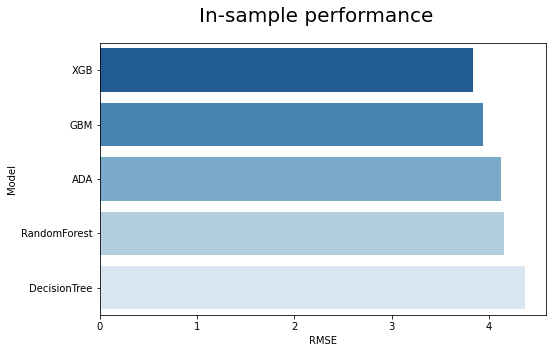

In [ ]:
ranking_boost = ranking_boost.sort_values(by='RMSE', ascending=True).reset_index(drop=True)

fig, ax = plt.subplots(figsize=(8, 5))
fig.suptitle("In-sample performance", fontsize=20)
sns.barplot(x="RMSE", y="Model", data=ranking_boost, ax=ax, palette = 'Blues_r');

The XGBoost and Gradient Boost perform best with RMSEs of 3.84 and 3.87 respectively. I find that the cross-validated RMSE of both the Decision Tree and Random Forest is higher than in the non-hyperparameter-optimised simple models fitted initially. This can be attributed to the fact that cross-validation counteracts overfitting to the training data.

In [ ]:
# check feature importance of the two best performing models
def feature_imp(coef, names):
    imp = coef
    indexes = np.argsort(imp)[-11:]
    indexes = list(indexes)
    
    plt.barh(range(len(indexes)), imp[indexes], align='center', color="lightblue")
    plt.yticks(range(len(indexes)), [names[i] for i in indexes])
    plt.show()
    
    return indexes

In [ ]:
feature_names = X_train.columns

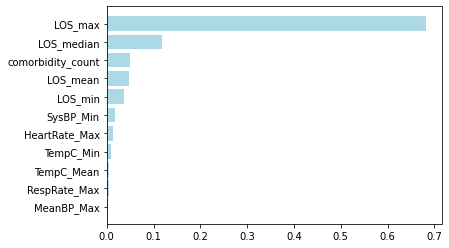

In [ ]:
xgb_opt = models[0].fit(X_train, y_train)
feat_indexes_xgb = feature_imp(abs(xgb_opt.feature_importances_), feature_names)

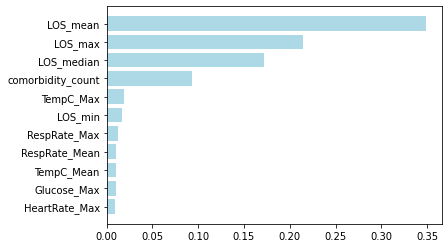

In [ ]:
gb_opt = models[1].fit(X_train, y_train)
feat_indexes_gb = feature_imp(abs(gb_opt.feature_importances_), feature_names)

Plotting the feature importance of both the XGBoost and the Gradient Boost, we see that the features constructed from the comorbidity data show the highest feature importance. This is in line with my observations from the data exploration section where I found these features to show the highest correlation with the target variable *LOS*.

In [ ]:
# save best model
boost_best_model = ranking_boost.Setting[0].fit(X_train, y_train)

file = 'pickles/boost_best.sav'
pickle.dump(boost_best_model, open(file, 'wb'))

In [ ]:
# load the model from disk and use it
boost_best_pickled = pickle.load(open('pickles/boost_best.sav', 'rb'))

y_pred_train_boost = boost_best_pickled.predict(X_train)
y_pred_test_boost = boost_best_pickled.predict(X_test)

print('RMSE : ' + str(sqrt(mean_squared_error(y_train, y_pred_train_boost))))
print('R-squared : ' + str(r2_score(y_train, y_pred_train_boost)))

RMSE : 3.3266322379488122
R-squared : 0.5868682094341859


Text(0.5, 1.0, 'R-squared equals 0.5868682094')

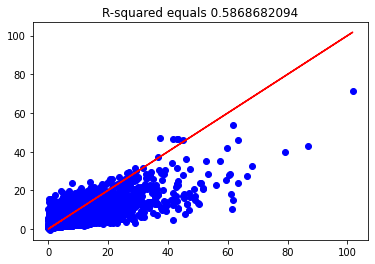

In [ ]:
plt.figure()
plt.scatter(x=y_train, y=y_pred_train_boost, color='blue') 
plt.plot(y_train,y_train,c="red")
rho2 = sklearn.metrics.r2_score(y_train,y_pred_train_boost)
plt.title('R-squared equals %.10f' % rho2)

In [ ]:
# Produce .csv for kaggle testing 
test_predictions_submit = pd.DataFrame({"icustay_id": data_test["icustay_id"], "LOS": y_pred_test_boost})
test_predictions_submit.to_csv("kaggle/test_predictions_submit_boost.csv", index = False)

I find that hyperparameter-optimisation and boosting positively impacts my kaggle score given that both these methods are known to increase predictive accuracy. 

## Other Ensemble Methods
Having seen that boosting improves the model performance, I now apply ensemble methods that combine different regression models to determine whether this yields further improvements. 

In [ ]:
%%time

# try out simple classifiers and see how they perform individually
models = [LinearRegression(),
          KNeighborsRegressor(n_neighbors=5),
          RandomForestRegressor(n_estimators=50, max_depth=5),
          SVR()]

names = ['Linear', 'KNN', 'RandomForest', 'SVR']
scores_regr = {}
predicted_LOS = {}

for i, model in enumerate(models):
    print(f"Fitting model {names[i]}...")
    
    model.fit(X_train, y_train)
    print(f"Best model fitted")
    
    y_train_hat = model.predict(X_train)
    predicted_LOS[names[i]] = (y_train_hat)
    rmse = sqrt(mean_squared_error(y_train, y_train_hat))
    
    # save in-sample rmse to dictionary
    scores_regr[names[i]] = (model, rmse)
    print(f'{names[i]} in-sample RMSE: {rmse}')

Fitting model Linear...
Best model fitted
Linear in-sample RMSE: 3.9803264376823675
Fitting model KNN...
Best model fitted
KNN in-sample RMSE: 3.61698408112798
Fitting model RandomForest...
Best model fitted
RandomForest in-sample RMSE: 3.758344258262709
Fitting model SVR...
Best model fitted
SVR in-sample RMSE: 4.140847535503159
CPU times: user 2min 13s, sys: 1.71 s, total: 2min 15s
Wall time: 2min 14s


In [ ]:
predicted_LOS

{'KNN': array([5.54296, 0.99534, 4.06774, ..., 2.0179 , 2.51684, 1.83822]),
 'Linear': array([ 3.86134043, -4.02215764,  3.57579049, ...,  0.52539798,
         1.83204028,  2.42500702]),
 'RandomForest': array([3.01253492, 1.0376389 , 3.74796942, ..., 1.59911989, 2.69300707,
        2.12283196]),
 'SVR': array([3.40904066, 1.09537253, 3.20459524, ..., 1.78277152, 1.81992545,
        1.74279219])}

In [ ]:
# look at correlation between models
predicted_LOS = pd.DataFrame.from_dict(predicted_LOS)
predicted_LOS.head()

Linear      KNN  RandomForest       SVR
0  3.861340  5.54296      3.012535  3.409041
1 -4.022158  0.99534      1.037639  1.095373
2  3.575790  4.06774      3.747969  3.204595
3  5.991897  5.08976      2.828139  3.387086
4  5.762900  3.67908      7.843786  4.428959

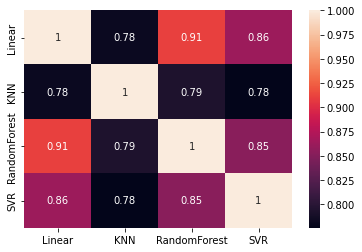

In [ ]:
sns.heatmap(predicted_LOS.corr(), annot=True)
plt.show()

The predictions of the Linear and RandomForest regression show a very high correlation at 0.91. Nonetheless, all correlations between the different regression models are less than 1. This suggests that combining the different models in an ensemble may increase the predictive performance of my model.

### Stacking

In [ ]:
meta_learners = [
    ExtraTreesRegressor(n_estimators=100, max_features=0.5, bootstrap=True, random_state=SEED),
    RandomForestRegressor(n_estimators=100, max_features=0.5, bootstrap=True, random_state=SEED),
    GradientBoostingRegressor(learning_rate=0.1, n_estimators=100, random_state=SEED)
]

meta_learners_ = ['ExtraTrees', 'RandomForest', 'GradientBoosting']

scores_ensemble = {}

for i, meta_learner in enumerate(meta_learners):
    super_learner = SuperLearner(folds=5, random_state=SEED)

    super_learner.add(models)
    super_learner.add_meta(meta_learner)
    super_learner.fit(X_train, y_train)

    y_train_hat = super_learner.predict(X_train)
    rmse = sqrt(mean_squared_error(y_train, y_train_hat))
    
    scores_ensemble[f'Stacking{meta_learners_[i]}'] = (super_learner, rmse)
    print(f'Super Learner with {meta_learners_[i]} in-sample RMSE: {rmse}')

Super Learner with ExtraTrees in-sample RMSE: 3.67632772015322
Super Learner with RandomForest in-sample RMSE: 3.6041646719635327
Super Learner with GradientBoosting in-sample RMSE: 3.6392233687806077


### Stacking with Feature Propagation

In [ ]:
models[2]

RandomForestRegressor(max_depth=5, n_estimators=50)

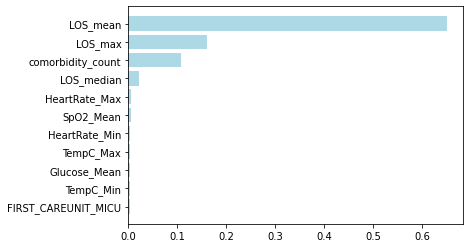

In [ ]:
feature_names = X_train.columns
rf_opt = models[2].fit(X_train, y_train)
feat_indexes_rf = feature_imp(abs(rf_opt.feature_importances_), feature_names)

In [ ]:
feat_to_prop = [feature_names[i] for i in feat_indexes_rf][-5:]
pointer = [i for i, feat in enumerate(feature_names) if feat in feat_to_prop]
X_train.columns[pointer]

Index(['HeartRate_Max', 'comorbidity_count', 'LOS_mean', 'LOS_median',
       'LOS_max'],
      dtype='object')

In [ ]:
feat_to_prop

['HeartRate_Max', 'LOS_median', 'comorbidity_count', 'LOS_max', 'LOS_mean']

In [ ]:
for i, meta_learner in enumerate(meta_learners):
    print(f'\nStackingPropagating {meta_learners_[i]}')
    super_learner = SuperLearner(folds=5, random_state=SEED)

    super_learner.add(models, propagate_features=pointer)
    super_learner.add_meta(meta_learner)
    super_learner.fit(X_train.values, y_train)
    
    y_train_hat = super_learner.predict(X_train.values)
    rmse = sqrt(mean_squared_error(y_train, y_train_hat))

    scores_ensemble[f'StackingPropagating{meta_learners_[i]}'] = (super_learner, rmse)
    print(f'Super Learner with {meta_learners_[i]} in-sample RMSE: {rmse}')


StackingPropagating ExtraTrees
Super Learner with ExtraTrees in-sample RMSE: 3.0105263552068258

StackingPropagating RandomForest
Super Learner with RandomForest in-sample RMSE: 2.9407009602645178

StackingPropagating GradientBoosting
Super Learner with GradientBoosting in-sample RMSE: 3.4922405192706174


### Blending

In [ ]:
for i, meta_learner in enumerate(meta_learners):
    blend_ensemble = bl =  BlendEnsemble(test_size=0.2, random_state=SEED, n_jobs=3)

    blend_ensemble.add(models)
    blend_ensemble.add_meta(meta_learner)
    blend_ensemble.fit(X_train, y_train)

    y_train_hat = blend_ensemble.predict(X_train)
    rmse = sqrt(mean_squared_error(y_train, y_train_hat))
    
    scores_ensemble[f'Blending{meta_learners_[i]}'] = (blend_ensemble, rmse)
    print(f'Blend Ensemble with {meta_learners_[i]} in-sample RMSE: {rmse}')

Blend Ensemble with ExtraTrees in-sample RMSE: 3.715258419585337
Blend Ensemble with RandomForest in-sample RMSE: 3.751243441919454
Blend Ensemble with GradientBoosting in-sample RMSE: 3.7805486379035607


### Blending with Feature Propagation

In [ ]:
for i, meta_learner in enumerate(meta_learners):
    print(f'\nBlendingPropagating {meta_learners_[i]}')
    blend_ensemble = bl =  BlendEnsemble(test_size=0.2, random_state=SEED, n_jobs=3)

    blend_ensemble.add(models, propagate_features=pointer)
    blend_ensemble.add_meta(meta_learner)
    blend_ensemble.fit(X_train.values, y_train)
    
    y_train_hat = blend_ensemble.predict(X_train.values)
    rmse = sqrt(mean_squared_error(y_train, y_train_hat))

    scores_ensemble[f'BlendingPropagating{meta_learners_[i]}'] = (blend_ensemble, rmse)
    print(f'Blend Ensemble with {meta_learners_[i]} in-sample RMSE: {rmse}')


BlendingPropagating ExtraTrees
Blend Ensemble with ExtraTrees in-sample RMSE: 3.533507928102677

BlendingPropagating RandomForest
Blend Ensemble with RandomForest in-sample RMSE: 3.5899986953365732

BlendingPropagating GradientBoosting
Blend Ensemble with GradientBoosting in-sample RMSE: 3.713903210309616


### Compare Performance

In [ ]:
ranking_ensemble = pd.DataFrame.from_dict(scores_ensemble, orient='index').reset_index()

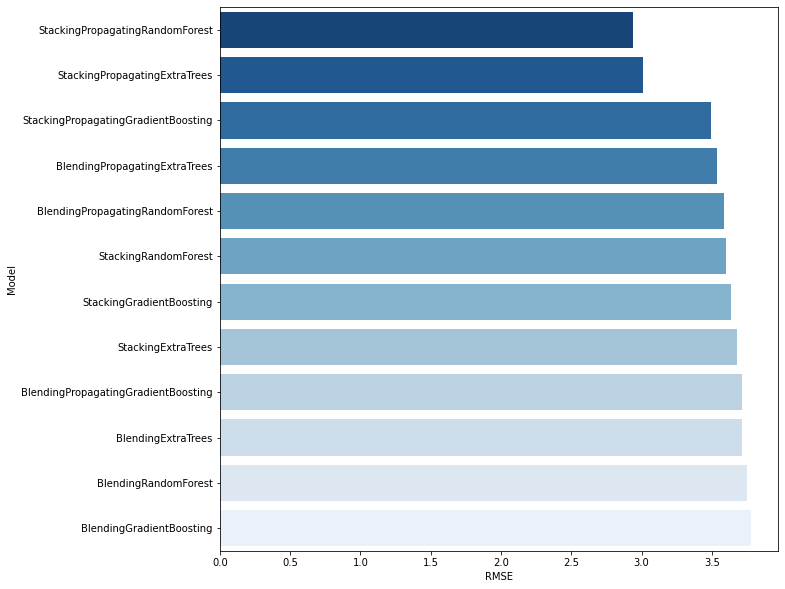

In [ ]:
ranking_ensemble.columns = ['Model', 'Setting', 'RMSE']
ranking_ensemble = ranking_ensemble.sort_values(by='RMSE', ascending=True).reset_index(drop=True)

fig, ax = plt.subplots(figsize=(10, 10))
sns.barplot(x="RMSE", y="Model", data=ranking_ensemble, ax=ax, palette = 'Blues_r');

The StackingPropagating models perform best. Overall, feature propagation seems to be superior to no feature propagation and stacking seems to be superior to blending.

In [ ]:
# save best model
ensemble_best_model = ranking_ensemble.Setting[0].fit(X_train.values, y_train)

file = 'pickles/ensemble_best.sav'
pickle.dump(ensemble_best_model, open(file, 'wb'))

In [ ]:
# load the model from disk and use it
ensemble_best_pickled = pickle.load(open('pickles/ensemble_best.sav', 'rb'))

y_pred_train_ensemble = ensemble_best_pickled.predict(X_train.values)
y_pred_test_ensemble = ensemble_best_pickled.predict(X_test.values)

print('RMSE : ' + str(sqrt(mean_squared_error(y_train, y_pred_train_ensemble))))
print('R-squared : ' + str(r2_score(y_train, y_pred_train_ensemble)))

RMSE : 2.970267788856306
R-squared : 0.670640463671675


Text(0.5, 1.0, 'R-squared equals 0.6706404637')

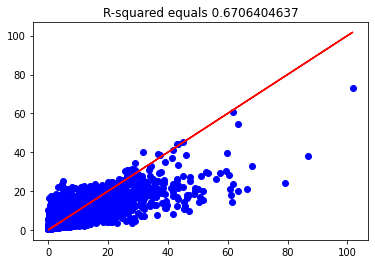

In [ ]:
plt.figure()
plt.scatter(x=y_train, y=y_pred_train_ensemble, color='blue') 
plt.plot(y_train,y_train,c="red")
rho2 = sklearn.metrics.r2_score(y_train,y_pred_train_ensemble)
plt.title('R-squared equals %.10f' % rho2)

In [ ]:
# Produce .csv for kaggle testing 
test_predictions_submit = pd.DataFrame({"icustay_id": data_test["icustay_id"], "LOS": y_pred_test_ensemble})
test_predictions_submit.to_csv("kaggle/test_predictions_submit_ensemble.csv", index = False)

## Overall Comparison of Models

In [ ]:
rankings = [ranking_boost, ranking_ensemble]
ranking = pd.concat(rankings)
ranking = ranking.sort_values(by=['RMSE'], ascending=True).reset_index(drop=True)
ranking.head()

Model  \
0      StackingPropagatingRandomForest   
1        StackingPropagatingExtraTrees   
2  StackingPropagatingGradientBoosting   
3        BlendingPropagatingExtraTrees   
4      BlendingPropagatingRandomForest   

                                             Setting      RMSE  
0  SuperLearner(array_check=None, backend=None, f...  2.940701  
1  SuperLearner(array_check=None, backend=None, f...  3.010526  
2  SuperLearner(array_check=None, backend=None, f...  3.492241  
3  BlendEnsemble(array_check=None, backend=None,\...  3.533508  
4  BlendEnsemble(array_check=None, backend=None,\...  3.589999

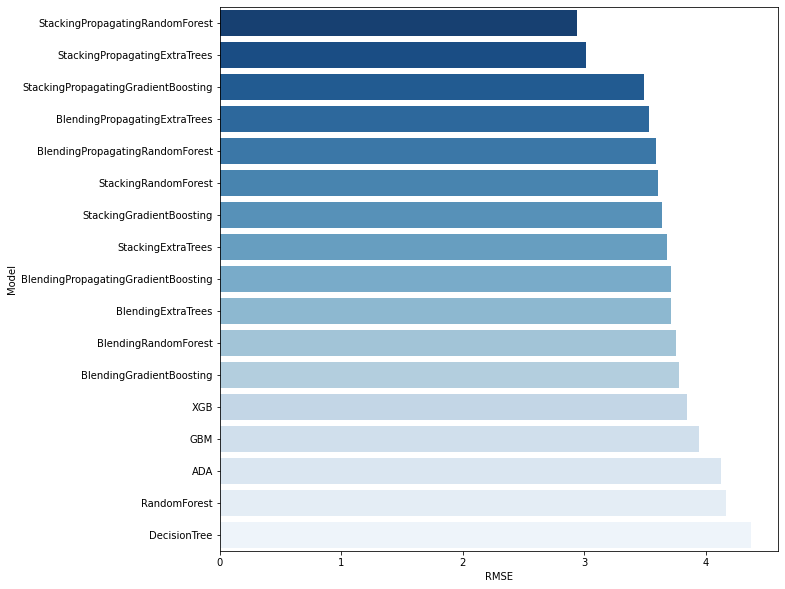

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.barplot(x="RMSE", y="Model", data=ranking, ax=ax, palette = 'Blues_r');

Overall, stacking and blending methods seems to outperform boosting, at least in terms of in-sample performance. Stacking with feature propagation performs best in-sample. If we take the kaggle score as a proxy of out-of-sample performance, then the XGBoost yields the best RMSE.

In [ ]:
# Save best model
best_model = ranking.Setting[0].fit(X_train.values, y_train)

file = 'pickles/best.sav'
pickle.dump(best_model, open(file, 'wb'))

## Model Interpretability
I apply model interpretability techniques to my best-performing model - Stacking with feature propagation. LIME is used to show which features are important for a single observation (local interpretability). I choose a random observation to show how the outputs of LIME can be interpreted. Subsequently, I use SHAP to extract the feature importance on the "global" level i.e. for the whole model.

### LIME for local interpretability

In [ ]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data = X_train.values,
    mode = 'regression',
    training_labels = y_train,
    feature_names = X_train.columns)

In [ ]:
# asking for explanation for the observation with index 1
observation_to_explain = 29 
exp = explainer.explain_instance(
    data_row = X_train.iloc[observation_to_explain].values, # the observation
    predict_fn = ensemble_best_pickled.predict) # the function to produce predictions

In [ ]:
exp.show_in_notebook()

The predicted length of stay for the patient that can be attributed to observation 29 is 2.03. This is situated at the lower end of possible values - the target variable *LOS* ranges from 0.63 to 18.85 days. *LOS_max* i.e. the max median length of stay associated with any of the patient's comorbidities is the most important determinant of *LOS* for this patient and affects *LOS* positively. The next most impactful variables are *icd9_diagnosis_Pregnancy* which negatively affects the *LOS* and *MeanBP_Mean* and *icd9_group_Blood* which push the *LOS* of this patient upwards. Note the feature impact is uniquely identified for the patient corresponding to observation 29.

### SHAP for global interpretability
Stacked ensembles are not yet supported by SHAP. I thus apply SHAP to the best-performing boosting model.

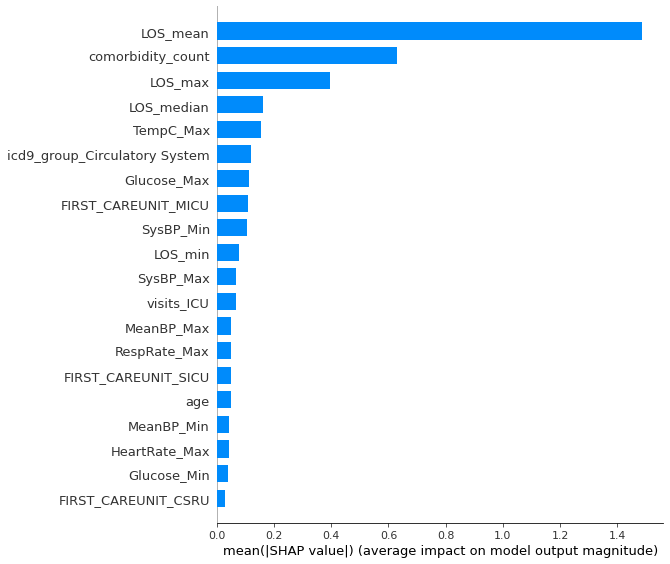

In [ ]:
explainer = shap.TreeExplainer(boost_best_pickled) 
shap_values = explainer.shap_values(X_train)
shap.initjs()
shap.summary_plot(shap_values, X_train, plot_type="bar")

We see that most of the features constructed from the comorbidity data have the higest feature importance. These include (from most impactful to least impactful) LOS_mean, comorbidity_count, LOS_max and LOS_median. This is very similar to the results I obtain when I directly plot feature importance after having fitted the XGBoost (see section Hyperparameter Optimisation and Boosting).

I next plot a summary of the effect of each feature on the final result. This is given in the plot below.

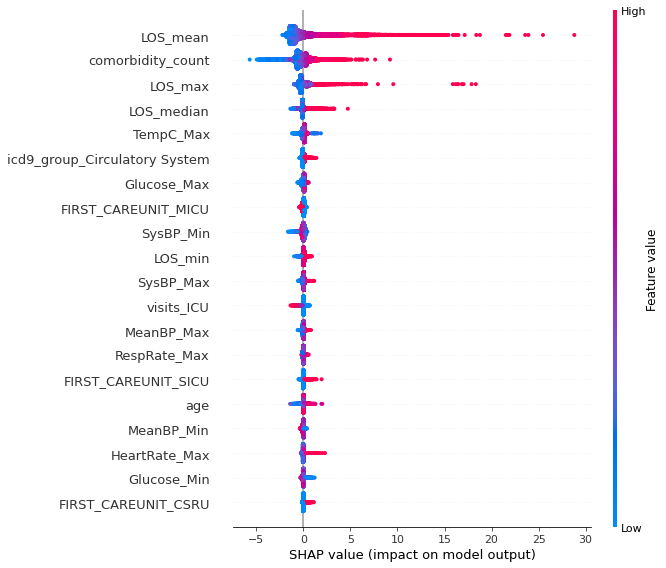

In [ ]:
features = X_train.columns
shap.summary_plot(shap_values, X_train, feature_names=features)

We see that the features with the highest feature importance mostly push the *LOS* upwards. Out of the 5 variables with the highest feature importance, only values for comorbidity count also have a significant impact on *LOS* in the negative direction.

Finally, I plot the contribution of each variable for observation 29. This belongs to the domain of local interpretability.

In [ ]:
# plot the explanation of one observation
mytarget = 29

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[mytarget,:], X_train.iloc[mytarget,:])

As is depicted in the graph, the predicted *LOS* for this patient is 2.52 days. The comorbidity count has the largest impact on *LOS* pushing it in the negative direction, as do *SysBP_Min* and *LOS_mean*. This is followed by *LOS_max* and *MeanBP_Max*, which each have a positive effect on *LOS*. As we move away from the prediction value of 2.52, we find variables that are less and less impactful for predicting the *LOS* of this particular patient at the local level. Note that all features were scaled before fitting the model which is why their assigned values cannot be directly interpreted.

## Extra: Neural Networks
Lastly, I try to fit some neural networks. Unfortunately, none of them are constructed in a way to outperform the various ensembling techniques I tried previously. Instead, the kaggle scores indicate that I am drastically overfitting to the training set.

In [ ]:
scores_nn = {}

### Neural Network using sklearn's MLPRegressor

In [ ]:
nn_mlp = MLPRegressor(solver='adam', alpha=1e-5, activation = 'relu', random_state=SEED)
nn_mlp.fit(X_train, y_train)

nn_params = {'learning_rate_init':[0.001, 0.01, 0.1],
             'hidden_layer_sizes':[10, 20, 30]}

nn_grid = GridSearchCV(nn_mlp, nn_params, n_jobs=4, cv=5, scoring='neg_mean_squared_error', verbose = 0)
nn_grid.fit(X_train, y_train)

y_pred_train_nn_mlp = nn_grid.predict(X_train)

# print scores
print('Chosen hyperparameters: ' + str(nn_grid.best_params_))
print('In-sample RMSE: ' + str(sqrt(-nn_grid.best_score_)))
print('R-squared: ' + str(r2_score(y_train, y_pred_train_nn_mlp)))

scores_nn['MLP'] = (nn_grid.best_estimator_, sqrt(mean_squared_error(y_train, y_pred_train_nn_mlp)))

Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


Chosen hyperparameters: {'hidden_layer_sizes': 10, 'learning_rate_init': 0.001}
In-sample RMSE: 3.8773938786632103
R-squared: 0.5041587317003786


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


Text(0.5, 1.0, 'R-squared equals 0.5041587317')

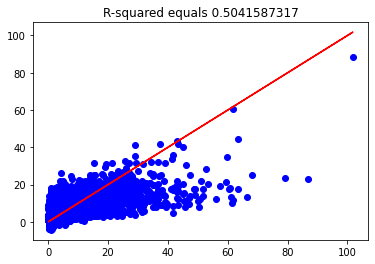

In [ ]:
plt.figure()
plt.scatter(x=y_train, y=y_pred_train_nn_mlp, color='blue') 
plt.plot(y_train,y_train,c="red")
rho2 = sklearn.metrics.r2_score(y_train,y_pred_train_nn_mlp)
plt.title('R-squared equals %.10f' % rho2)

In [ ]:
y_pred_test_nn_mlp = nn_grid.predict(X_test)

In [ ]:
y_pred_test_nn_mlp

array([4.50256631, 8.10446386, 5.88791772, ..., 1.61525429, 2.44976485,
       1.09203046])

In [ ]:
# Produce .csv for kaggle testing 
test_predictions_submit = pd.DataFrame({"icustay_id": data_test["icustay_id"], "LOS": y_pred_test_nn_mlp})
test_predictions_submit.to_csv("kaggle/test_predictions_submit_nn_mlp.csv", index = False)

First kaggle submission had an RMSE of 79. This indicates that this model is drastically overfitting.

### Neural Network using tensorflow
I experiment with dropout layers using tensorflow to try and prevent overfitting.

In [ ]:
# determine the number of input features
n_features = X_train.shape[1]

# define model
nn_keras = Sequential()
nn_keras.add(Dense(30, activation='relu', kernel_initializer='he_normal', input_shape=(n_features,)))
nn_keras.add(Dropout(0.2))
nn_keras.add(Dense(30, activation='relu', kernel_initializer='he_normal'))
nn_keras.add(Dropout(0.2))
nn_keras.add(Dense(30, activation='relu', kernel_initializer='he_normal', input_shape=(n_features,)))
nn_keras.add(Dropout(0.2))
nn_keras.add(Dense(1))

nn_keras.compile(optimizer='adam', loss='mse')
nn_keras.fit(X_train, y_train, epochs=10, batch_size=25, verbose=0)

y_pred_train_nn_keras = nn_keras.predict(X_train)

error = nn_keras.evaluate(X_train, y_train, verbose=0)

print('RMSE : ' + str(sqrt(error)))
print('R-squared : ' + str(r2_score(y_train, y_pred_train_nn_mlp)))

scores_nn['NNKeras'] = ('NA', sqrt(error))

RMSE : 3.7304652987958513
R-squared : 0.5041587317003786


In [ ]:
# determine the number of input features
n_features = X_train.shape[1]

# define model
nn_keras = Sequential()
nn_keras.add(Dense(64, input_shape=(n_features,), kernel_initializer='normal', activation='relu'))
nn_keras.add(Dense(32, kernel_initializer='normal', activation='relu'))
nn_keras.add(Dense(16, kernel_initializer='normal', activation='relu'))
nn_keras.add(Dense(8, kernel_initializer='normal', activation='relu'))
nn_keras.add(Dense(4, kernel_initializer='normal', activation='relu'))
nn_keras.add(Dense(1, kernel_initializer='normal'))

nn_keras.compile(loss='mean_squared_error', optimizer = 'adam')
nn_keras.fit(X_train, y_train, epochs=10, batch_size=25, verbose=0)

y_pred_train_nn_keras = nn_keras.predict(X_train)

error = nn_keras.evaluate(X_train, y_train, verbose=0)

print('RMSE : ' + str(sqrt(error)))
print('R-squared : ' + str(r2_score(y_train, y_pred_train_nn_mlp)))

scores_nn['NNKeras2'] = ('NA', sqrt(error))

RMSE : 3.789361245874217
R-squared : 0.5041587317003786


In [ ]:
# determine the number of input features
n_features = X_train.shape[1]

# define model
nn_keras = Sequential()
nn_keras.add(Dense(64, input_shape=(n_features,), kernel_initializer='normal', activation='relu'))
nn_keras.add(Dropout(0.1))
nn_keras.add(Dense(32, kernel_initializer='normal', activation='relu'))
nn_keras.add(Dropout(0.1))
nn_keras.add(Dense(16, kernel_initializer='normal', activation='relu'))
nn_keras.add(Dropout(0.1))
nn_keras.add(Dense(8, kernel_initializer='normal', activation='relu'))
nn_keras.add(Dropout(0.1))
nn_keras.add(Dense(4, kernel_initializer='normal', activation='relu'))
nn_keras.add(Dropout(0.1))
nn_keras.add(Dense(1, kernel_initializer='normal'))

nn_keras.compile(loss='mean_squared_error', optimizer = 'adam')
nn_keras.fit(X_train, y_train, epochs=10, batch_size=25, verbose=0)

y_pred_train_nn_keras = nn_keras.predict(X_train)

error = nn_keras.evaluate(X_train, y_train, verbose=0)

print('RMSE : ' + str(sqrt(error)))
print('R-squared : ' + str(r2_score(y_train, y_pred_train_nn_mlp)))

scores_nn['NNKeras3'] = ('NA', sqrt(error))

RMSE : 3.8365310240850508
R-squared : 0.5041587317003786


In [ ]:
scores_nn

{'MLP': (MLPRegressor(alpha=1e-05, hidden_layer_sizes=10, random_state=42),
  3.644448513178714),
 'NNKeras': ('NA', 3.7304652987958513),
 'NNKeras2': ('NA', 3.789361245874217),
 'NNKeras3': ('NA', 3.8365310240850508)}

In [ ]:
ranking_nn = pd.DataFrame.from_dict(scores_nn, orient='index').reset_index()
ranking_nn.columns = ['Model', 'Setting', 'RMSE']

### Assess relative performance of Neural Network

---



In [ ]:
rankings = [ranking_boost, ranking_ensemble, ranking_nn]
ranking = pd.concat(rankings)
ranking = ranking.sort_values(by=['RMSE'], ascending=True).reset_index(drop=True)
ranking.head()

Model  \
0      StackingPropagatingRandomForest   
1        StackingPropagatingExtraTrees   
2  StackingPropagatingGradientBoosting   
3        BlendingPropagatingExtraTrees   
4      BlendingPropagatingRandomForest   

                                             Setting      RMSE  
0  SuperLearner(array_check=None, backend=None, f...  2.940701  
1  SuperLearner(array_check=None, backend=None, f...  3.010526  
2  SuperLearner(array_check=None, backend=None, f...  3.492241  
3  BlendEnsemble(array_check=None, backend=None,\...  3.533508  
4  BlendEnsemble(array_check=None, backend=None,\...  3.589999

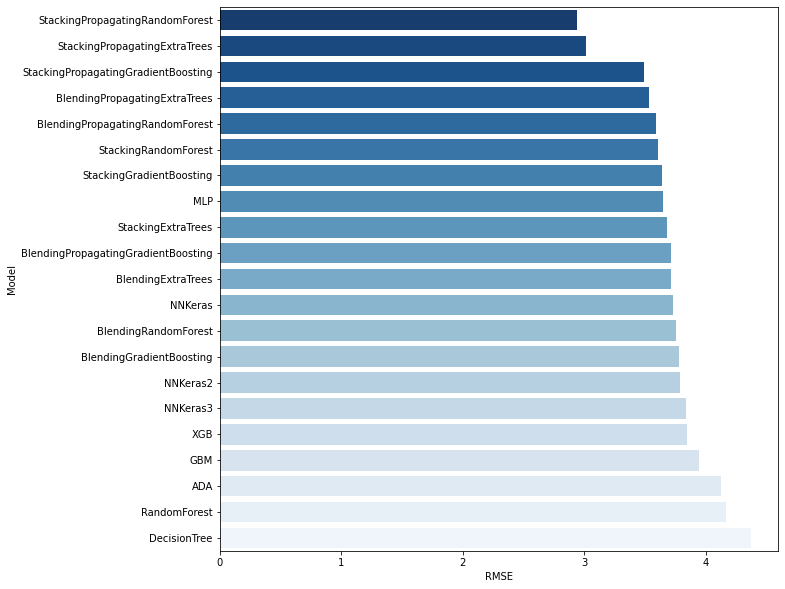

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.barplot(x="RMSE", y="Model", data=ranking, ax=ax, palette = 'Blues_r');

My neural networks seem have better in-sample predictions than the boosting methods. However, they are outperformed by Stacking and Blending Ensembles. I assume that I would have to tweak the layers more to better fit the data. Neural networks have the highest versatility of all models, so they should in theory be able to outperform ensemble methods. Unfortunately, I don't have time to experiment more...